# Import Data

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys


sys.path.append('../analysis_scripts')

In [7]:
data_oc_df = pd.read_csv('/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Data/analysed_signal.csv')
data_mb_df = pd.read_csv('/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Data/analysed_background.csv')

In [8]:
data_oc_df = data_oc_df.drop(['n_event'], axis=1)
mass_mask = (data_oc_df['mass_Lc'] > 2.24763) & ( data_oc_df['mass_Lc'] < 2.32497) & (data_oc_df['true_decay'] == 1)
data_oc_df = data_oc_df[mass_mask]
data_oc_df['tag'] = 'Sig'

data_mb_df = data_mb_df.drop(['n_event'], axis=1)
mass_mask = (data_mb_df['mass_Lc'] > 2.24763) & ( data_mb_df['mass_Lc'] < 2.32497)
data_mb_df = data_mb_df[mass_mask]
data_mb_df['tag'] = 'Bg'

raw_df = pd.concat([data_oc_df, data_mb_df], axis=0).reset_index(drop=True)

raw_df['cosAngle_r_Lc_momentum_Lc'] = raw_df['cosAngle_r_Lc_momentum_Lc'].apply(np.cos)
raw_df['cosAngle_r_Lc_sum_momentum'] = raw_df['cosAngle_r_Lc_sum_momentum'].apply(np.cos)
raw_df['cosAngle_momentum_Lc_sum_momentum'] = raw_df['cosAngle_momentum_Lc_sum_momentum'].apply(np.cos)

raw_df['cosAngle_r_Lc_momentum_Lc_left'] = raw_df.loc[raw_df['cosAngle_r_Lc_momentum_Lc'] < 0, 'cosAngle_r_Lc_momentum_Lc']
raw_df['cosAngle_r_Lc_momentum_Lc_right'] = raw_df.loc[raw_df['cosAngle_r_Lc_momentum_Lc'] > 0, 'cosAngle_r_Lc_momentum_Lc']

raw_df['cosAngle_r_Lc_sum_momentum_left'] = raw_df.loc[raw_df['cosAngle_r_Lc_sum_momentum'] < 0, 'cosAngle_r_Lc_sum_momentum']
raw_df['cosAngle_r_Lc_sum_momentum_right'] = raw_df.loc[raw_df['cosAngle_r_Lc_sum_momentum'] > 0, 'cosAngle_r_Lc_sum_momentum']

# Raw Data Stats

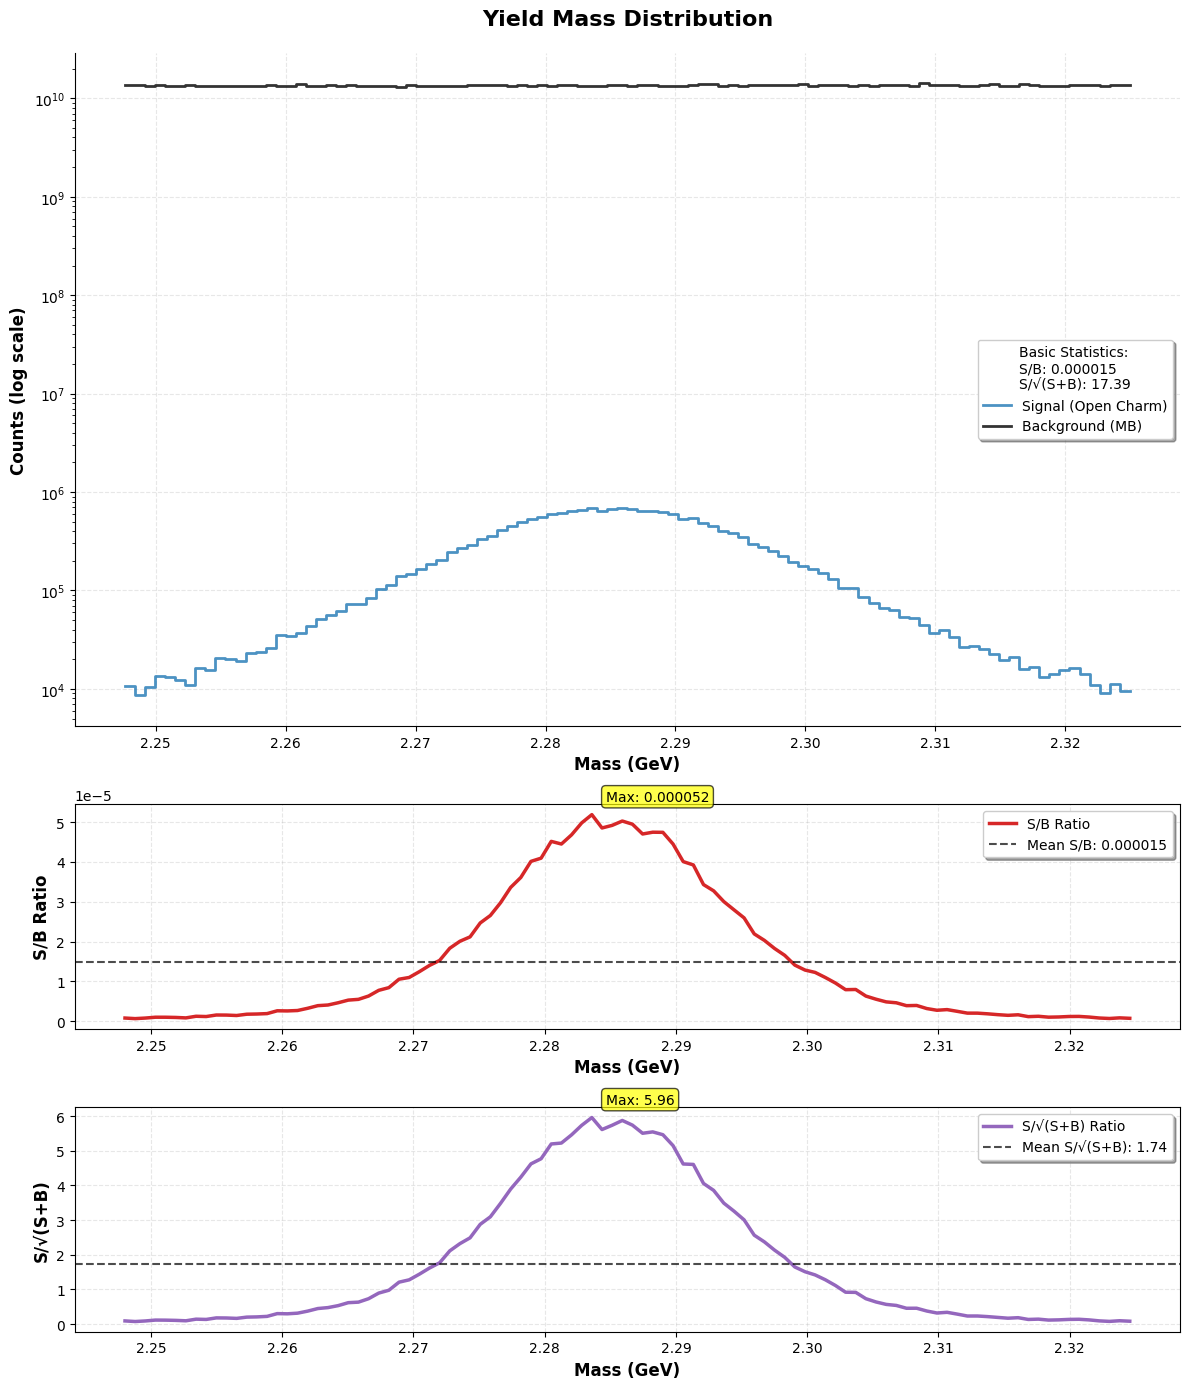


SUMMARY STATISTICS
Total Signal Events: 20213325
Total Background Events: 1351019295183
Total Signal Events Unscaled: 98685
Total Background Events Unscaled: 441934
Overall S/B Ratio: 0.000015
Overall S/sqrt(S+B) Significance: 17.39
Maximum S/B Ratio: 0.000052 at 2.284 GeV
Maximum S/sqrt(S+B): 5.96 at 2.284 GeV


In [9]:
from estimate_scripts import signal_estimates


sig_mass_distr = raw_df.loc[raw_df['tag'] == 'Sig', 'mass_Lc']
bg_mass_distr = raw_df.loc[raw_df['tag'] == 'Bg', 'mass_Lc']

_ = signal_estimates(
    sig_mass_distr=sig_mass_distr, 
    bg_mass_distr=bg_mass_distr, 
    have_sig_events=2.1555 * 1e6,
    have_bg_events=39.2 * 1e6, 
    mass_interval=(2.24763, 2.32497), 
    visualization=True
)

# Preselect Data

In [10]:
from selection_scripts import auto_preselection


proc_df = raw_df.copy()

feature_to_remove = ['mass_Lc', 'cosAngle_r_Lc_momentum_Lc', 'cosAngle_r_Lc_sum_momentum',
                     'phi_angle', 'multiplicity', 'Lc_diff_x', 'Lc_diff_y', 'Lc_diff_z',
                     'PV_diff_x', 'PV_diff_y', 'PV_diff_z', 'PV_diff_ES_x', 'PV_diff_ES_y',
                     'PV_diff_ES_z', 'true_decay', 'tag']

features_to_select = list(proc_df.columns)

for feature in feature_to_remove:
    features_to_select.remove(feature)

selection_df, mask = auto_preselection(
    df=proc_df,
    features=features_to_select,
    safety_interval=0.9,
    indent=2,
    quantile_left=1e-2,
    quantile_right=1-1e-2,
    recursive=True
)

proc_df = proc_df.query(mask)

sig_eff_presel = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count() / raw_df.loc[raw_df['tag'] == 'Sig', 'mass_Lc'].count()
bg_eff_presel = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count() / raw_df.loc[raw_df['tag'] == 'Bg', 'mass_Lc'].count()

print(f'Signal efficiency: {sig_eff_presel}')
print(f'Background Suppression: {bg_eff_presel}')

Signal efficiency: 0.7099863201094391
Background Suppression: 0.22423710327786503


In [11]:
selection_df

,cut_feature,left_cut,right_cut,sig_efficiency,MB_efficiency
0,P_p,NaN,3.600354,0.989998,0.967061
1,P_pip,NaN,1.618419,0.990000,0.969376
2,P_K,NaN,2.965913,0.989992,0.973649
3,eta_Lc,NaN,1.836843,0.989995,0.844479
4,length_Lc,-0.050274,0.069469,0.979999,0.824691
5,dLength_Lc,NaN,0.033477,0.990000,0.922416
6,ctau_Lc,-0.044925,0.061460,0.979993,0.866899
7,chi2_Lc_PV,0.001208,2.054425,0.979984,0.960612
8,dist_Lc_PV,NaN,0.008381,0.989992,0.949974
9,chi2_p_PV,0.002084,1.688898,0.979987,0.976799


# Data Stats After Preselection

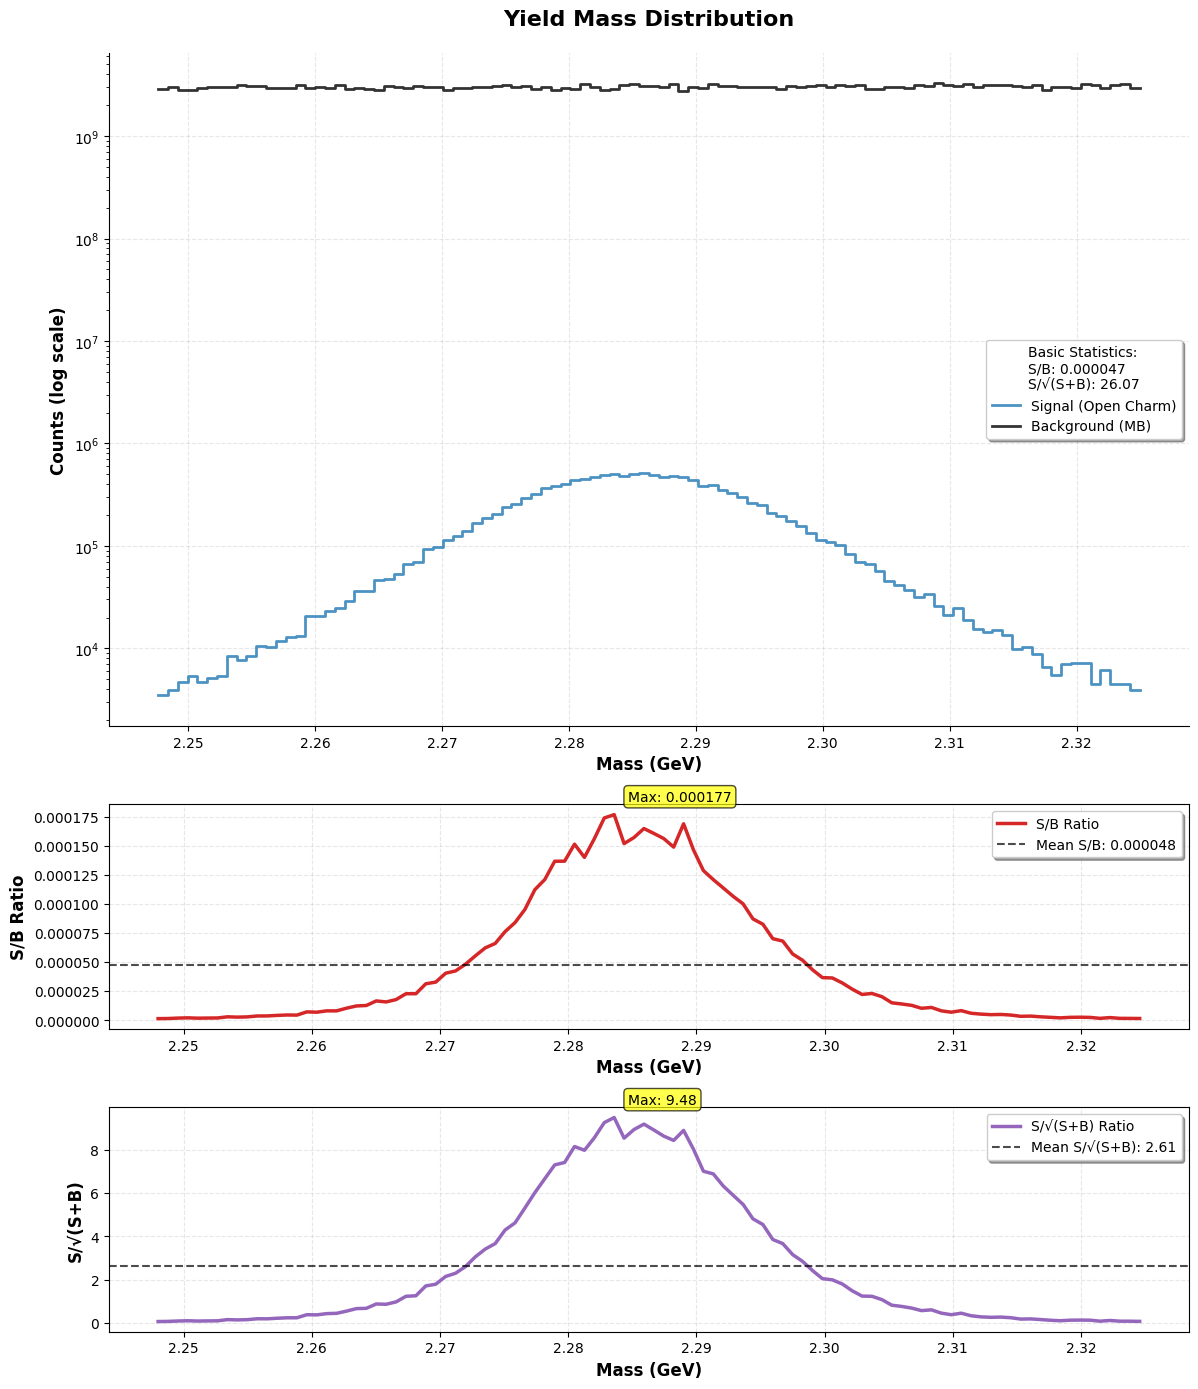


SUMMARY STATISTICS
Total Signal Events: 14351184
Total Background Events: 302948653224
Total Signal Events Unscaled: 70065
Total Background Events Unscaled: 99098
Overall S/B Ratio: 0.000047
Overall S/sqrt(S+B) Significance: 26.07
Maximum S/B Ratio: 0.000177 at 2.284 GeV
Maximum S/sqrt(S+B): 9.48 at 2.284 GeV


In [ ]:
from estimate_scripts import signal_estimates


sig_mass_distr = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc']
bg_mass_distr = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc']


_ = signal_estimates(
    sig_mass_distr=sig_mass_distr, 
    bg_mass_distr=bg_mass_distr, 
    have_sig_events=2.1555 * 1e6, 
    have_bg_events=39.2 * 1e6, 
    mass_interval=(2.24763, 2.32497), 
    visualization=True
)

# Selection Path SetUp

In [8]:
topolog_columns = [
    'chi2_Lc_PV', 'dist_Lc_PV', 'chi2_p_PV', 'dist_p_PV',
    'Chi2_K_PV', 'dist_K_PV', 'chi2_pip_PV', 'dist_pip_PV', 'chi2_p_Lc', 'dist_p_Lc',
    'chi2_K_Lc', 'dist_K_Lc', 'chi2_pip_Lc', 'dist_pip_Lc',
    'chi2_Lc', 'chi2_K_pip', 'dist_K_pip', 'chi2_p_K', 'dist_p_K', 'chi2_p_pip', 'dist_p_pip', 
    'cosAngle_momentum_Lc_sum_momentum'
]

extra_top = ['cosAngle_r_Lc_momentum_Lc', 'cosAngle_r_Lc_sum_momentum']

phys_columns = [
    'length_Lc', 'dLength_Lc', 'lengthXY_Lc', 'dLengthXY_Lc',
    'mass_Lc', 'P_p', 'P_pip', 'P_K', 'P_Lc', 'eta_p', 'eta_pip', 'eta_K',
    'eta_Lc', 'Pt_Lc', 'Pt_p', 'Pt_K', 'Pt_pip', 'ctau_Lc', 'OA_p', 'OA_K', 'OA_pip', 'ptOverE'
]

In [9]:
"""from scripts import create_best_selection_path


search_columns = [
    'length_Lc', 'dLength_Lc', 'lengthXY_Lc', 'dLengthXY_Lc',
    'chi2_Lc_PV', 'dist_Lc_PV', 'chi2_p_PV', 'dist_p_PV',
    'Chi2_K_PV', 'dist_K_PV', 'chi2_pip_PV', 'dist_pip_PV', 'chi2_p_Lc', 'dist_p_Lc',
    'chi2_K_Lc', 'chi2_pip_Lc', 'dist_pip_Lc',
    'chi2_Lc', 'chi2_K_pip', 'dist_K_pip', 'chi2_p_K', 'chi2_p_pip', 'dist_p_pip', 
    'cosAngle_momentum_Lc_sum_momentum'
]

result_df = create_best_selection_path(
    proc_df[['mass_Lc', 'tag'] + search_columns],
    features=search_columns, 
    n_features_to_use=None, 
    metric_type='tpr_fpr',
    have_sig_events=2.1555 * 1e6,
    have_bg_events=39.2 * 1e6,
    mass_interval=(2.24763, 2.32497),
    direction_restrictions={'length_Lc': 'right', 'dLength_Lc': 'right', 'lengthXY_Lc': 'right', 'dLengthXY_Lc': 'right'}
)"""

"from scripts import create_best_selection_path\n\n\nsearch_columns = [\n    'length_Lc', 'dLength_Lc', 'lengthXY_Lc', 'dLengthXY_Lc',\n    'chi2_Lc_PV', 'dist_Lc_PV', 'chi2_p_PV', 'dist_p_PV',\n    'Chi2_K_PV', 'dist_K_PV', 'chi2_pip_PV', 'dist_pip_PV', 'chi2_p_Lc', 'dist_p_Lc',\n    'chi2_K_Lc', 'chi2_pip_Lc', 'dist_pip_Lc',\n    'chi2_Lc', 'chi2_K_pip', 'dist_K_pip', 'chi2_p_K', 'chi2_p_pip', 'dist_p_pip', \n    'cosAngle_momentum_Lc_sum_momentum'\n]\n\nresult_df = create_best_selection_path(\n    proc_df[['mass_Lc', 'tag'] + search_columns],\n    features=search_columns, \n    n_features_to_use=None, \n    metric_type='tpr_fpr',\n    have_sig_events=2.1555 * 1e6,\n    have_bg_events=39.2 * 1e6,\n    mass_interval=(2.24763, 2.32497),\n    direction_restrictions={'length_Lc': 'right', 'dLength_Lc': 'right', 'lengthXY_Lc': 'right', 'dLengthXY_Lc': 'right'}\n)"

# Selection Var 1

In [12]:
total_sig_efficiency = 1
total_bg_suppression = 1

### Cut 1

Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
Cut point: 0.01657111472495763
Signal efficiency: 0.715036037964747
Background Suppression: 0.3555571252699348


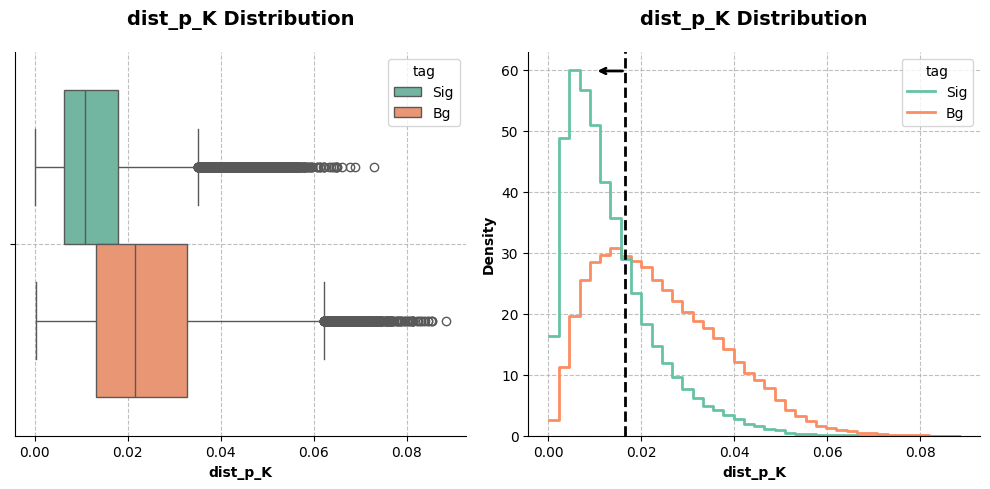

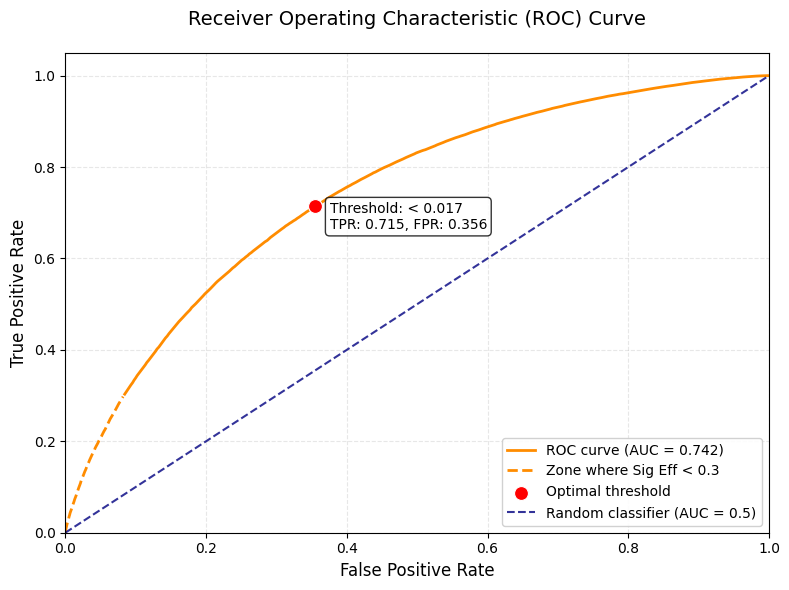

In [13]:
from draw_scripts import draw_feature_distribution
from draw_scripts import draw_roc
from selection_scripts import find_optimal_cut_point


feature = 'dist_p_K'
select_direction = 'left'
metric_type = 'tpr_fpr'
bounds = None
min_sig_sel = 0.3
temp_df = proc_df.copy()

num_sig_before_sel = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count()
num_bg_before_sel = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count()

min_sig_sel_mask, best_arg, metric_1, metric_2, thresholds, sig_efficiency, bg_efficiency = find_optimal_cut_point(
    df=proc_df[['mass_Lc', 'tag', feature]],
    feature=feature,
    bounds=bounds,
    select_direction=select_direction,
    metric_type=metric_type,
    min_sig_sel=min_sig_sel,
    have_sig_events=2.1555 * 1e6,
    have_bg_events=39.2 * 1e6,
    mass_interval=(2.24763, 2.32497)
)

if bounds is not None:
    bounds_mask = (temp_df[feature] >= bounds[0]) & (temp_df[feature] <= bounds[1])
    temp_df = temp_df[bounds_mask]
    
best_cut_x = thresholds[min_sig_sel_mask][best_arg]
best_tpr = metric_1[min_sig_sel_mask][best_arg]
best_fpr = metric_2[min_sig_sel_mask][best_arg]

draw_feature_distribution(
    df=temp_df,
    distr_name=feature,
    tag=None,
    hue='tag',
    bins=40,
    norma=True,
    cut_point=best_cut_x,
    select_direction=select_direction
)

plt.savefig(f'../plots/{feature}_cut.pdf')

if metric_type not in ['significance', 'ratio']:
    
    _ = draw_roc(
        tpr=metric_1,
        fpr=metric_2,
        best_cut_x=best_cut_x,
        best_tpr=best_tpr,
        best_fpr=best_fpr,
        select_direction=select_direction,
        mask=min_sig_sel_mask,
        min_sig_sel=min_sig_sel
    )

    plt.savefig(f'../plots/{feature}_roc_auc.pdf')
  
if select_direction == 'right':
    proc_df = proc_df[proc_df[feature] > best_cut_x]
else:
    proc_df = proc_df[proc_df[feature] < best_cut_x]

print(f'Cut point: {best_cut_x}')

sig_eff = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count() / num_sig_before_sel
bg_eff = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count() / num_bg_before_sel

total_sig_efficiency *= sig_eff
total_bg_suppression *= bg_eff

print(f'Signal efficiency: {sig_eff}')
print(f'Background Suppression: {bg_eff}')

### Cut 2

Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
Cut point: 0.006553183676810689
Signal efficiency: 0.6850236531667299
Background Suppression: 0.46311905775507306


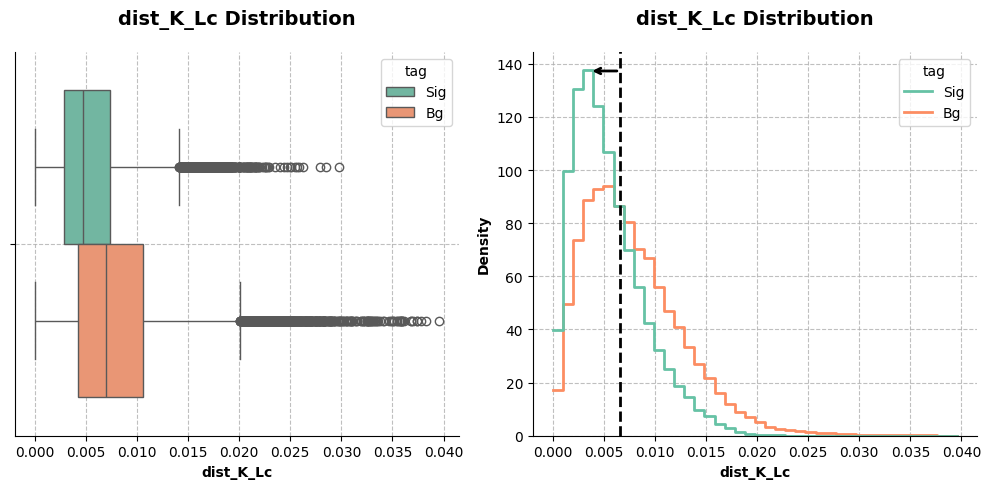

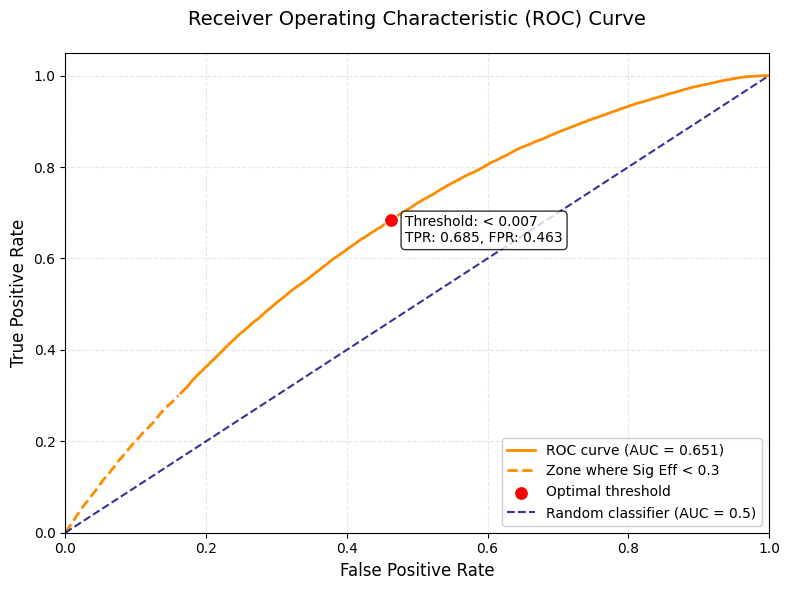

In [ ]:
from draw_scripts import draw_feature_distribution
from draw_scripts import draw_roc
from selection_scripts import find_optimal_cut_point


feature = 'dist_K_Lc'
select_direction = 'left'
metric_type = 'tpr_fpr'
bounds = None
min_sig_sel = 0.3
temp_df = proc_df.copy()

num_sig_before_sel = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count()
num_bg_before_sel = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count()

min_sig_sel_mask, best_arg, metric_1, metric_2, thresholds, sig_efficiency, bg_efficiency = find_optimal_cut_point(
    df=proc_df[['mass_Lc', 'tag', feature]],
    feature=feature,
    bounds=bounds,
    select_direction=select_direction,
    metric_type=metric_type,
    min_sig_sel=min_sig_sel,
    have_sig_events=2.1555 * 1e6,
    have_bg_events=39.2 * 1e6,
    mass_interval=(2.24763, 2.32497)
)

if bounds is not None:
    bounds_mask = (temp_df[feature] >= bounds[0]) & (temp_df[feature] <= bounds[1])
    temp_df = temp_df[bounds_mask]
    
best_cut_x = thresholds[min_sig_sel_mask][best_arg]
best_tpr = metric_1[min_sig_sel_mask][best_arg]
best_fpr = metric_2[min_sig_sel_mask][best_arg]

draw_feature_distribution(
    df=temp_df,
    distr_name=feature,
    tag=None,
    hue='tag',
    bins=40,
    norma=True,
    cut_point=best_cut_x,
    select_direction=select_direction
)

plt.savefig(f'../plots/{feature}_cut.pdf')

if metric_type not in ['significance', 'ratio']:
    
    _ = draw_roc(
        tpr=metric_1,
        fpr=metric_2,
        best_cut_x=best_cut_x,
        best_tpr=best_tpr,
        best_fpr=best_fpr,
        select_direction=select_direction,
        mask=min_sig_sel_mask,
        min_sig_sel=min_sig_sel
    )

    plt.savefig(f'../plots/{feature}_roc_auc.pdf')
  
if select_direction == 'right':
    proc_df = proc_df[proc_df[feature] > best_cut_x]
else:
    proc_df = proc_df[proc_df[feature] < best_cut_x]

print(f'Cut point: {best_cut_x}')

sig_eff = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count() / num_sig_before_sel
bg_eff = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count() / num_bg_before_sel

total_sig_efficiency *= sig_eff
total_bg_suppression *= bg_eff

print(f'Signal efficiency: {sig_eff}')
print(f'Background Suppression: {bg_eff}')

### Cut 3

Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
Cut point: 0.9999999261312222
Signal efficiency: 0.7335586701244209
Background Suppression: 0.5723127834293418


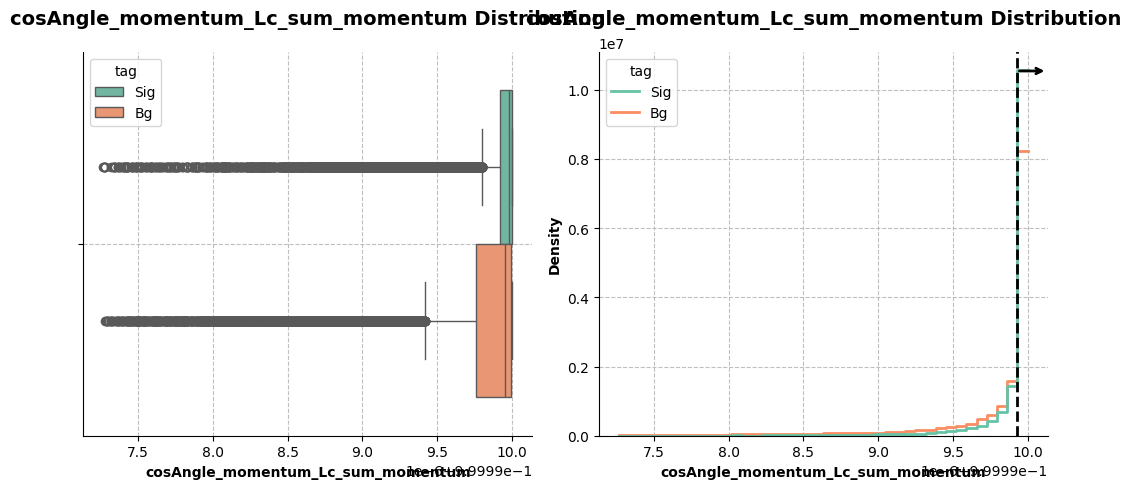

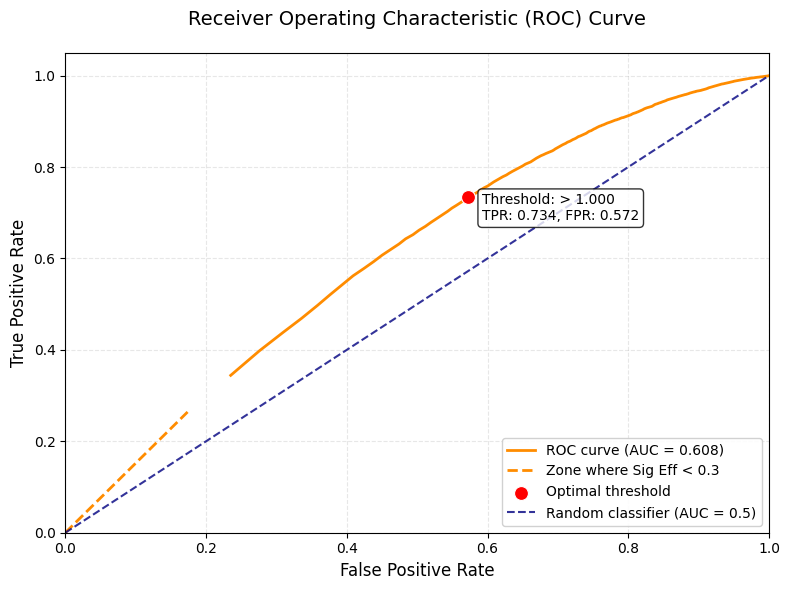

In [ ]:
from draw_scripts import draw_feature_distribution
from draw_scripts import draw_roc
from selection_scripts import find_optimal_cut_point


feature = 'cosAngle_momentum_Lc_sum_momentum'
select_direction = 'right'
metric_type = 'tpr_fpr'
bounds = None
min_sig_sel = 0.3
temp_df = proc_df.copy()

num_sig_before_sel = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count()
num_bg_before_sel = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count()

min_sig_sel_mask, best_arg, metric_1, metric_2, thresholds, sig_efficiency, bg_efficiency = find_optimal_cut_point(
    df=proc_df[['mass_Lc', 'tag', feature]],
    feature=feature,
    bounds=bounds,
    select_direction=select_direction,
    metric_type=metric_type,
    min_sig_sel=min_sig_sel,
    have_sig_events=2.1555 * 1e6,
    have_bg_events=39.2 * 1e6,
    mass_interval=(2.24763, 2.32497)
)

if bounds is not None:
    bounds_mask = (temp_df[feature] >= bounds[0]) & (temp_df[feature] <= bounds[1])
    temp_df = temp_df[bounds_mask]
    
best_cut_x = thresholds[min_sig_sel_mask][best_arg]
best_tpr = metric_1[min_sig_sel_mask][best_arg]
best_fpr = metric_2[min_sig_sel_mask][best_arg]

draw_feature_distribution(
    df=temp_df,
    distr_name=feature,
    tag=None,
    hue='tag',
    bins=40,
    norma=True,
    cut_point=best_cut_x,
    select_direction=select_direction
)

plt.savefig(f'../plots/{feature}_cut.pdf')

if metric_type not in ['significance', 'ratio']:
    
    _ = draw_roc(
        tpr=metric_1,
        fpr=metric_2,
        best_cut_x=best_cut_x,
        best_tpr=best_tpr,
        best_fpr=best_fpr,
        select_direction=select_direction,
        mask=min_sig_sel_mask,
        min_sig_sel=min_sig_sel
    )

    plt.savefig(f'../plots/{feature}_roc_auc.pdf')
  
if select_direction == 'right':
    proc_df = proc_df[proc_df[feature] > best_cut_x]
else:
    proc_df = proc_df[proc_df[feature] < best_cut_x]

print(f'Cut point: {best_cut_x}')

sig_eff = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count() / num_sig_before_sel
bg_eff = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count() / num_bg_before_sel

total_sig_efficiency *= sig_eff
total_bg_suppression *= bg_eff

print(f'Signal efficiency: {sig_eff}')
print(f'Background Suppression: {bg_eff}')

### Cut 4

Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
Cut point: 1.8183079783443932
Signal efficiency: 0.7621052631578947
Background Suppression: 0.20366206231930614


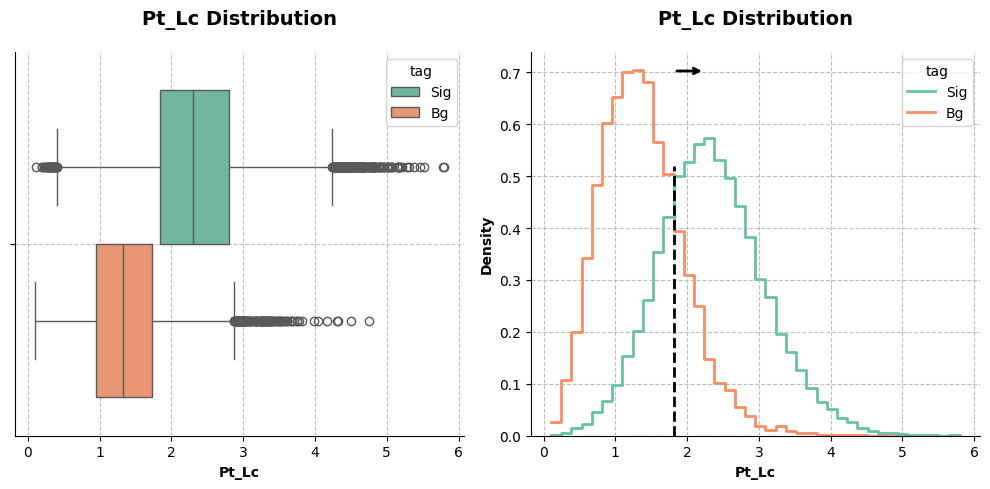

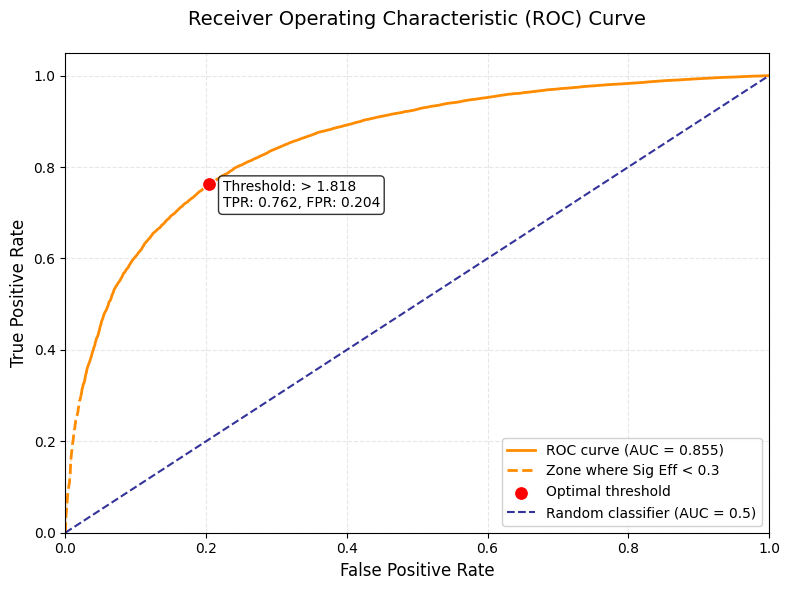

In [ ]:
from draw_scripts import draw_feature_distribution
from draw_scripts import draw_roc
from selection_scripts import find_optimal_cut_point


feature = 'Pt_Lc'
select_direction = 'right'
metric_type = 'tpr_fpr'
bounds = None
min_sig_sel = 0.3
temp_df = proc_df.copy()

num_sig_before_sel = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count()
num_bg_before_sel = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count()

min_sig_sel_mask, best_arg, metric_1, metric_2, thresholds, sig_efficiency, bg_efficiency = find_optimal_cut_point(
    df=proc_df[['mass_Lc', 'tag', feature]],
    feature=feature,
    bounds=bounds,
    select_direction=select_direction,
    metric_type=metric_type,
    min_sig_sel=min_sig_sel,
    have_sig_events=2.1555 * 1e6,
    have_bg_events=39.2 * 1e6,
    mass_interval=(2.24763, 2.32497)
)

if bounds is not None:
    bounds_mask = (temp_df[feature] >= bounds[0]) & (temp_df[feature] <= bounds[1])
    temp_df = temp_df[bounds_mask]
    
best_cut_x = thresholds[min_sig_sel_mask][best_arg]
best_tpr = metric_1[min_sig_sel_mask][best_arg]
best_fpr = metric_2[min_sig_sel_mask][best_arg]

draw_feature_distribution(
    df=temp_df,
    distr_name=feature,
    tag=None,
    hue='tag',
    bins=40,
    norma=True,
    cut_point=best_cut_x,
    select_direction=select_direction
)

plt.savefig(f'../plots/{feature}_cut.pdf')

if metric_type not in ['significance', 'ratio']:
    
    _ = draw_roc(
        tpr=metric_1,
        fpr=metric_2,
        best_cut_x=best_cut_x,
        best_tpr=best_tpr,
        best_fpr=best_fpr,
        select_direction=select_direction,
        mask=min_sig_sel_mask,
        min_sig_sel=min_sig_sel
    )

    plt.savefig(f'../plots/{feature}_roc_auc.pdf')

if select_direction == 'right':
    proc_df = proc_df[proc_df[feature] > best_cut_x]
else:
    proc_df = proc_df[proc_df[feature] < best_cut_x]

print(f'Cut point: {best_cut_x}')


sig_eff = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count() / num_sig_before_sel
bg_eff = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count() / num_bg_before_sel

total_sig_efficiency *= sig_eff
total_bg_suppression *= bg_eff

print(f'Signal efficiency: {sig_eff}')
print(f'Background Suppression: {bg_eff}')

### Cut 5

Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
Cut point: 0.0036779999382443238
Signal efficiency: 0.526217033253414
Background Suppression: 0.2939011566771819


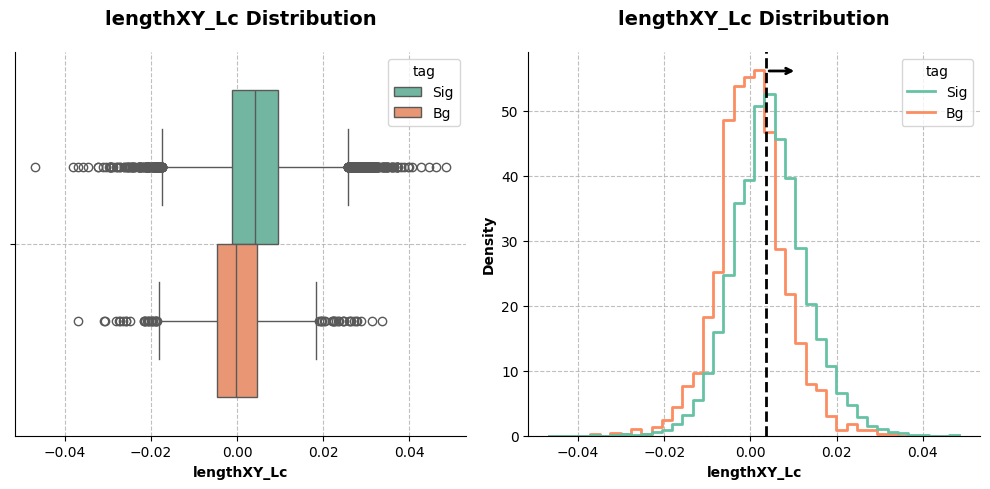

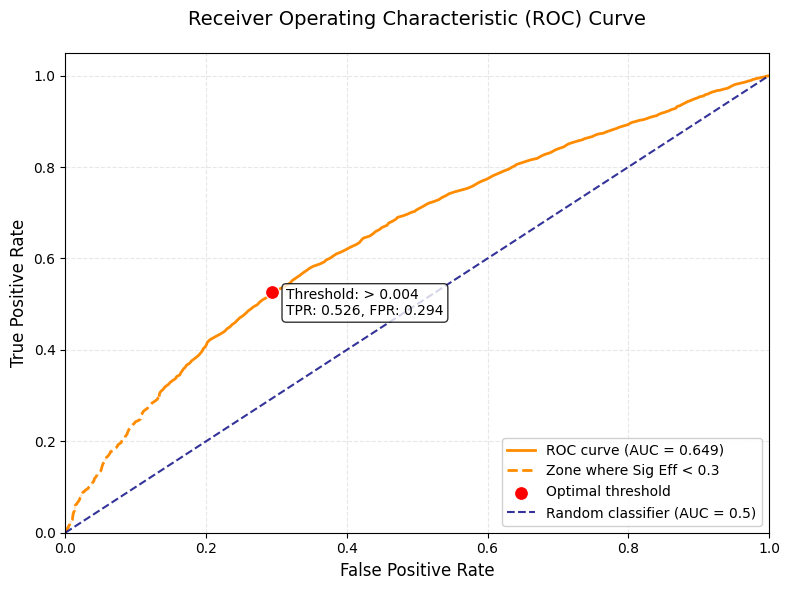

In [ ]:
from draw_scripts import draw_feature_distribution
from draw_scripts import draw_roc
from selection_scripts import find_optimal_cut_point


feature = 'lengthXY_Lc'
select_direction = 'right'
metric_type = 'tpr_fpr'
bounds = None
min_sig_sel = 0.3
temp_df = proc_df.copy()

num_sig_before_sel = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count()
num_bg_before_sel = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count()

min_sig_sel_mask, best_arg, metric_1, metric_2, thresholds, sig_efficiency, bg_efficiency = find_optimal_cut_point(
    df=proc_df[['mass_Lc', 'tag', feature]],
    feature=feature,
    bounds=bounds,
    select_direction=select_direction,
    metric_type=metric_type,
    min_sig_sel=min_sig_sel,
    have_sig_events=2.1555 * 1e6,
    have_bg_events=39.2 * 1e6,
    mass_interval=(2.24763, 2.32497)
)

if bounds is not None:
    bounds_mask = (temp_df[feature] >= bounds[0]) & (temp_df[feature] <= bounds[1])
    temp_df = temp_df[bounds_mask]
    
best_cut_x = thresholds[min_sig_sel_mask][best_arg]
best_tpr = metric_1[min_sig_sel_mask][best_arg]
best_fpr = metric_2[min_sig_sel_mask][best_arg]

draw_feature_distribution(
    df=temp_df,
    distr_name=feature,
    tag=None,
    hue='tag',
    bins=40,
    norma=True,
    cut_point=best_cut_x,
    select_direction=select_direction
)

plt.savefig(f'../plots/{feature}_cut.pdf')

if metric_type not in ['significance', 'ratio']:
    
    _ = draw_roc(
        tpr=metric_1,
        fpr=metric_2,
        best_cut_x=best_cut_x,
        best_tpr=best_tpr,
        best_fpr=best_fpr,
        select_direction=select_direction,
        mask=min_sig_sel_mask,
        min_sig_sel=min_sig_sel
    )

    plt.savefig(f'../plots/{feature}_roc_auc.pdf')
  
if select_direction == 'right':
    proc_df = proc_df[proc_df[feature] > best_cut_x]
else:
    proc_df = proc_df[proc_df[feature] < best_cut_x]

print(f'Cut point: {best_cut_x}')

sig_eff = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count() / num_sig_before_sel
bg_eff = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count() / num_bg_before_sel

total_sig_efficiency *= sig_eff
total_bg_suppression *= bg_eff

print(f'Signal efficiency: {sig_eff}')
print(f'Background Suppression: {bg_eff}')

# Data Stats After Selection

In [24]:
print(f'Total signal efficiency: {total_sig_efficiency}')
print(f'Total background suppression: {total_bg_suppression}')

print(f'\nTotal signal efficiency (include presel): {total_sig_efficiency * sig_eff_presel}')
print(f'Total background suppression (include presel): {total_bg_suppression * bg_eff_presel}')

Total signal efficiency: 0.07058000973690877
Total background suppression: 0.0009288572119085259

Total signal efficiency (include presel): 0.05011084138639624
Total background suppression (include presel): 0.00020828425055712188


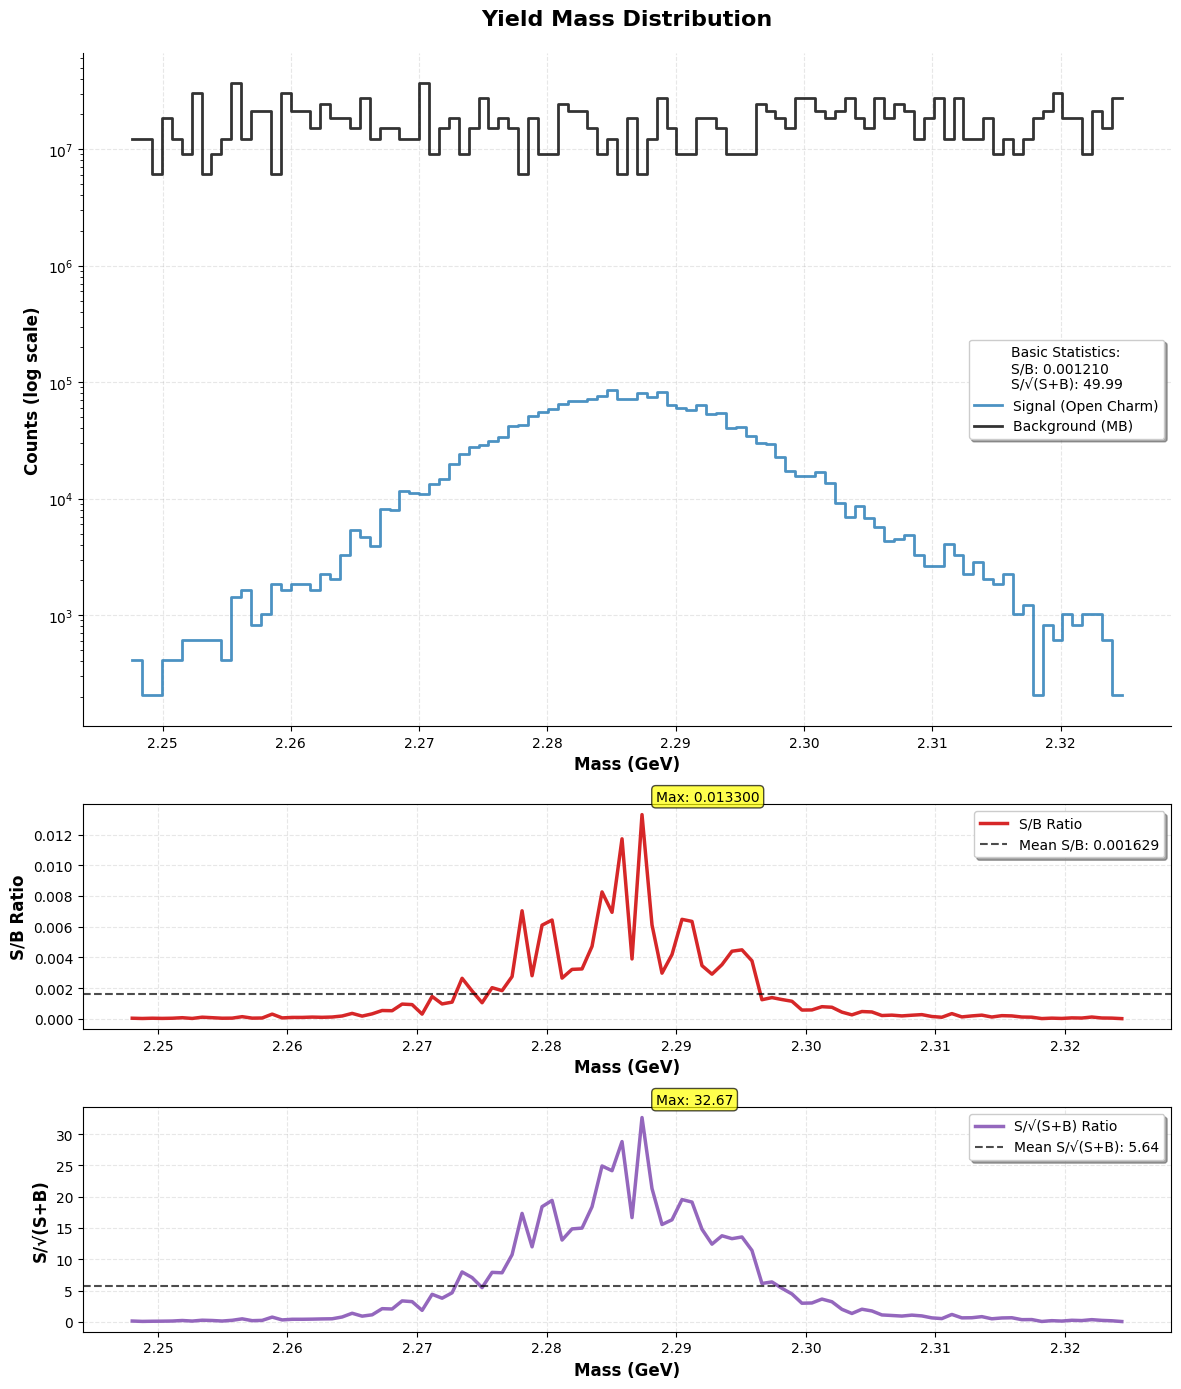


SUMMARY STATISTICS
Total Signal Events: 2067931
Total Background Events: 1708897224
Total Signal Events Unscaled: 10096
Total Background Events Unscaled: 559
Overall S/B Ratio: 0.001210
Overall S/sqrt(S+B) Significance: 49.99
Maximum S/B Ratio: 0.013300 at 2.287 GeV
Maximum S/sqrt(S+B): 32.67 at 2.287 GeV


<Figure size 640x480 with 0 Axes>

In [ ]:
from estimate_scripts import signal_estimates


sig_mass_distr = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc']
bg_mass_distr = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc']


_ = signal_estimates(
    sig_mass_distr=sig_mass_distr, 
    bg_mass_distr=bg_mass_distr, 
    have_sig_events=2.1555 * 1e6, 
    have_bg_events=39.2 * 1e6, 
    mass_interval=(2.24763, 2.32497), 
    visualization=True
)

plt.savefig(f'../plots/mass_distr.pdf')

# Features After Selection

/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Analysis/scripts.py:252: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


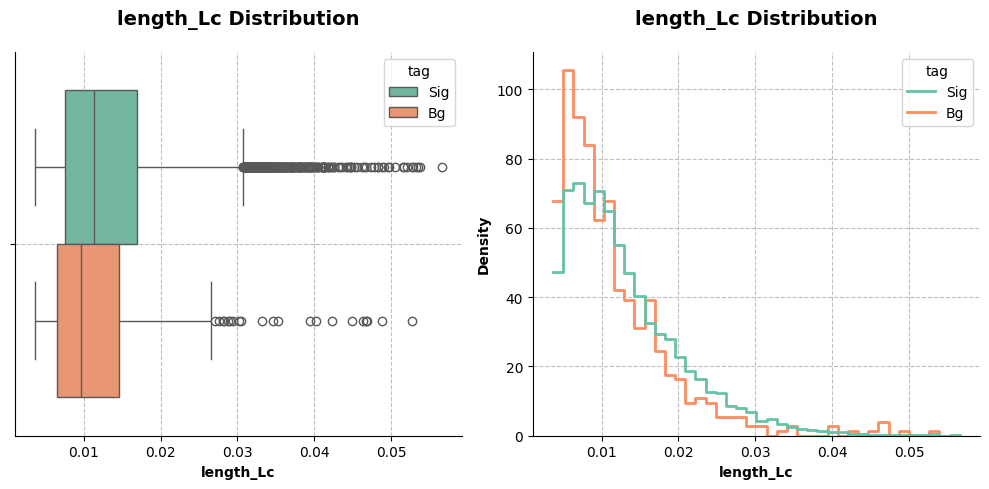

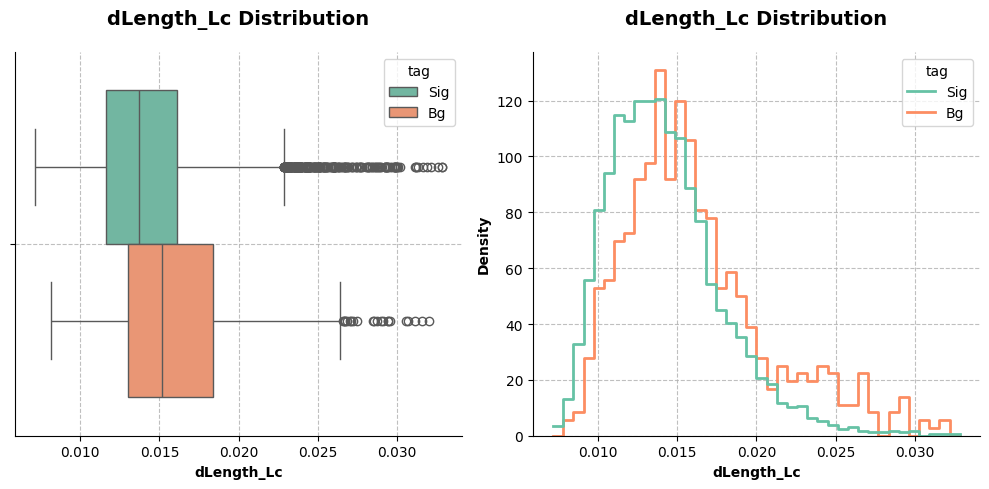

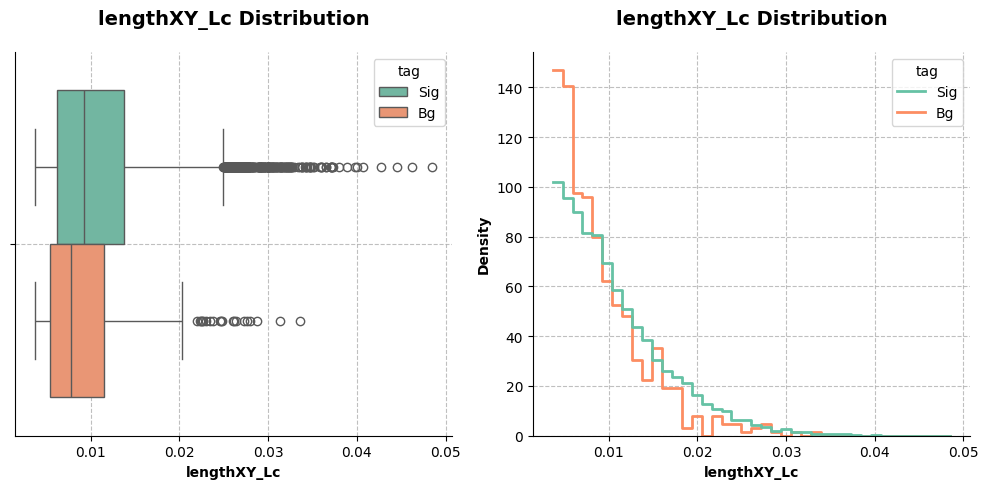

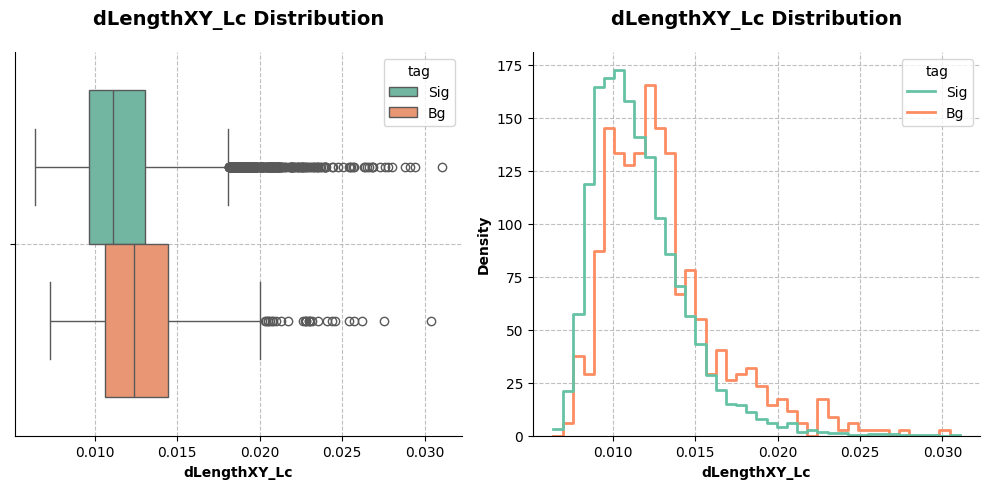

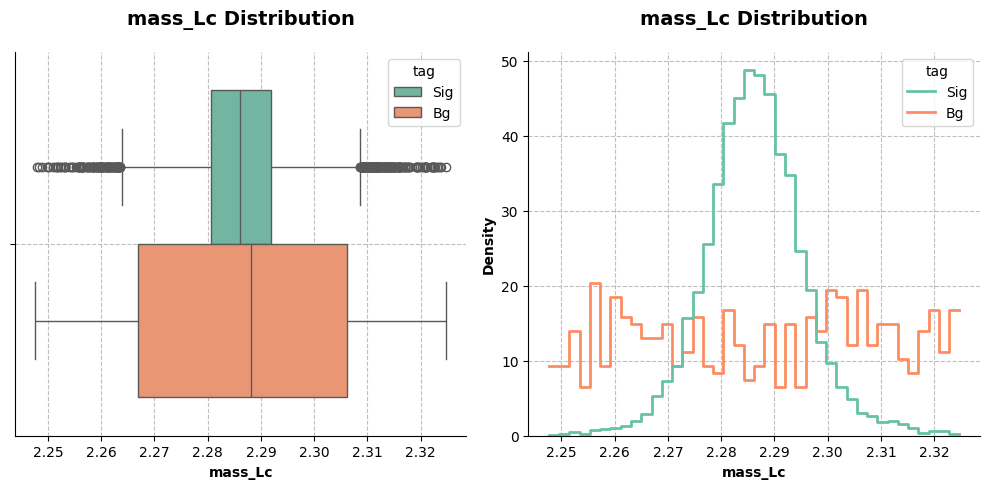

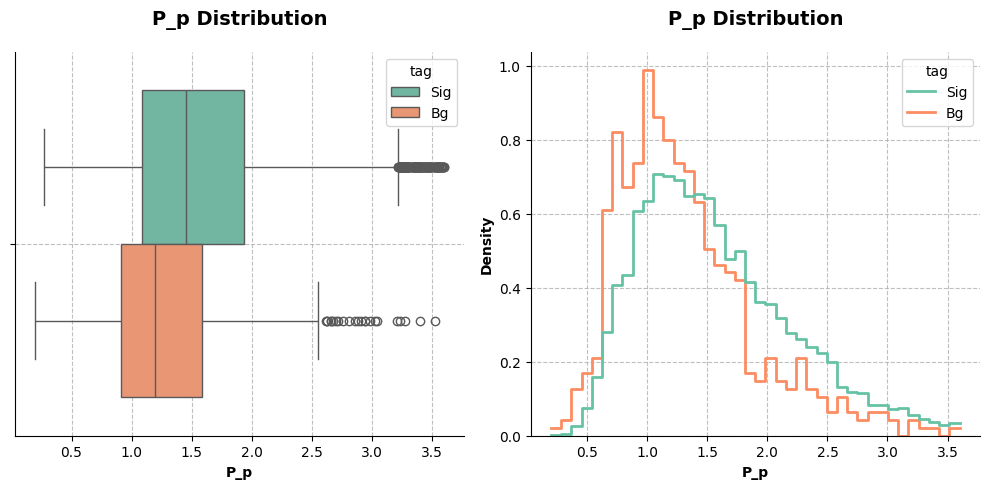

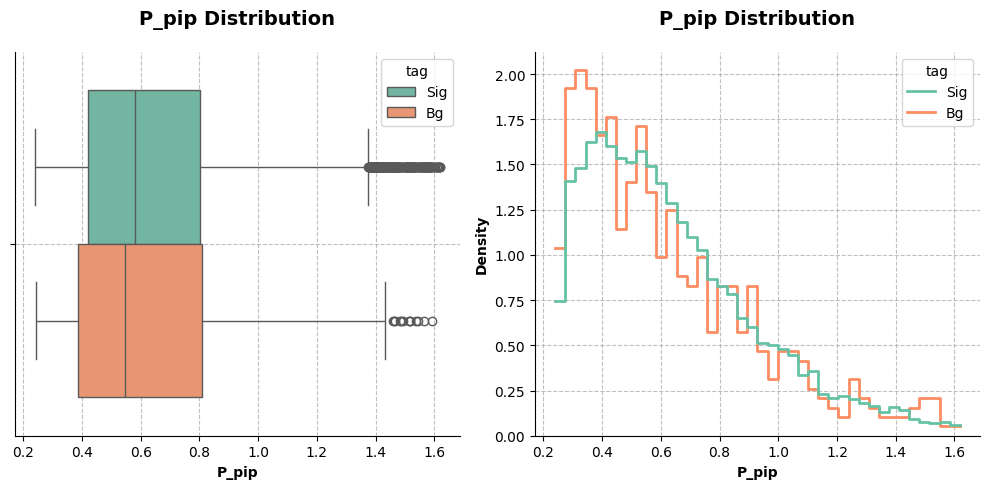

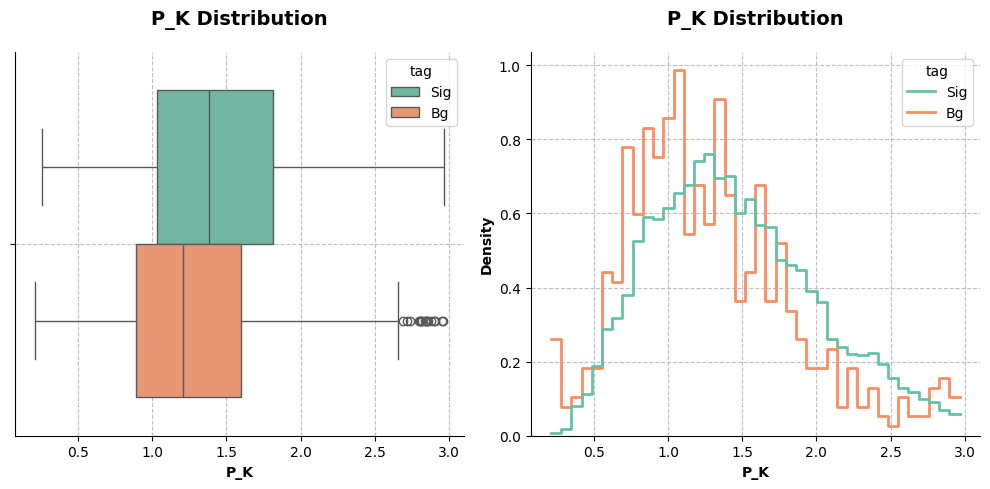

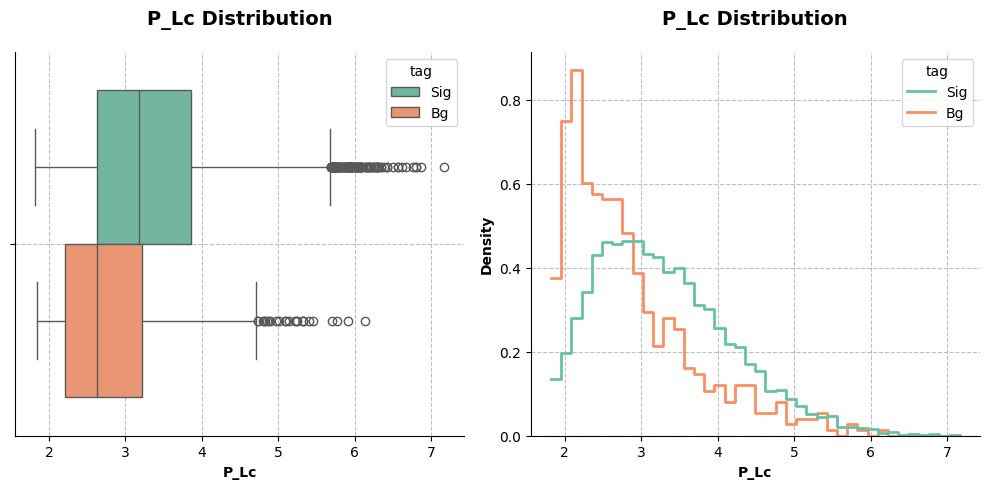

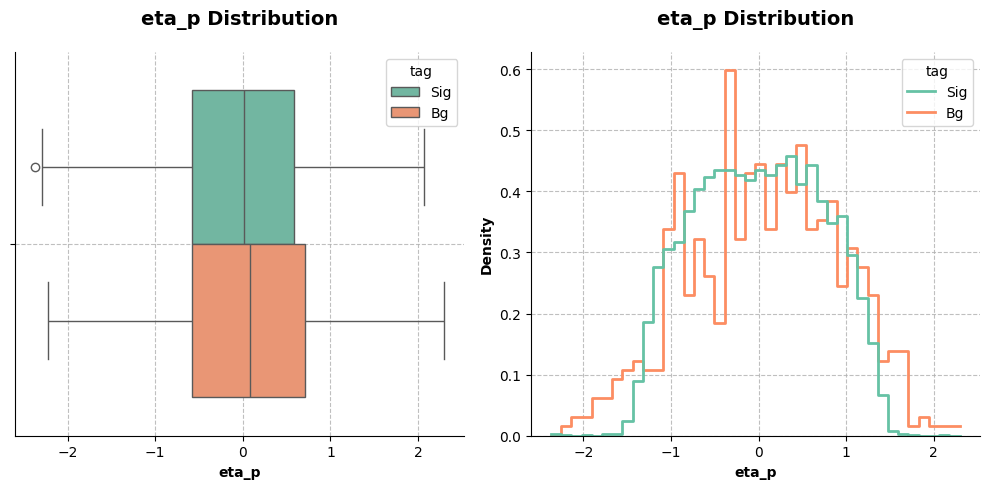

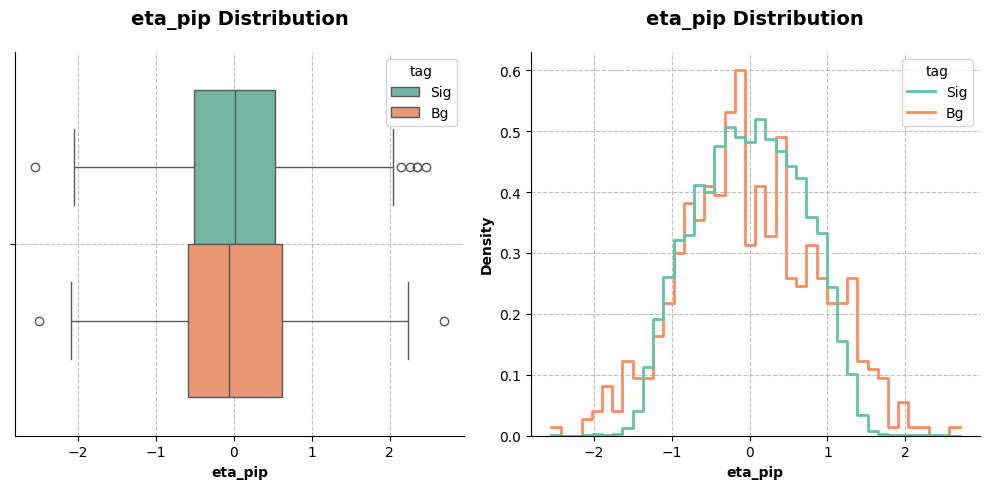

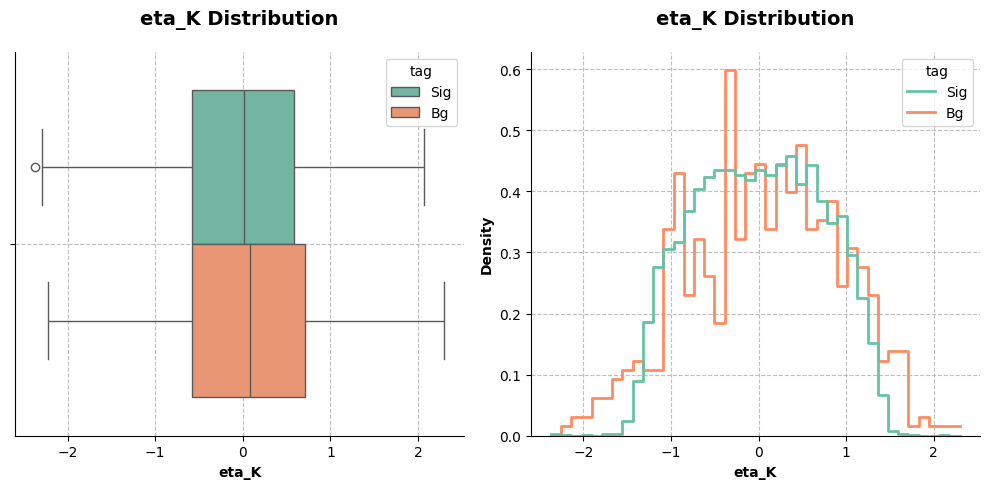

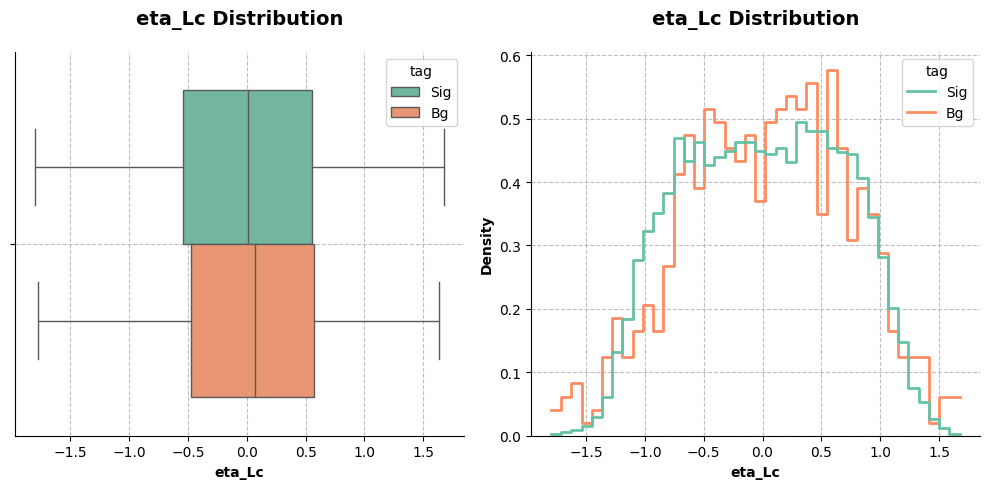

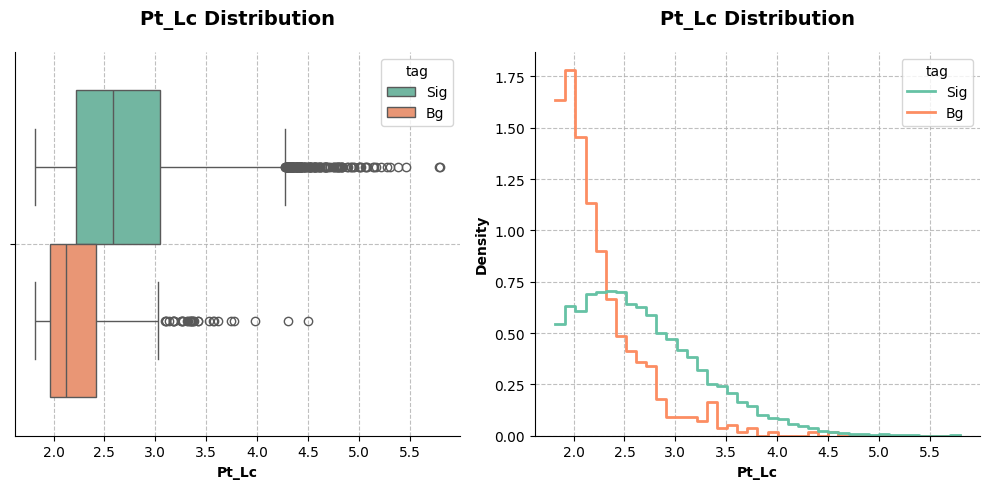

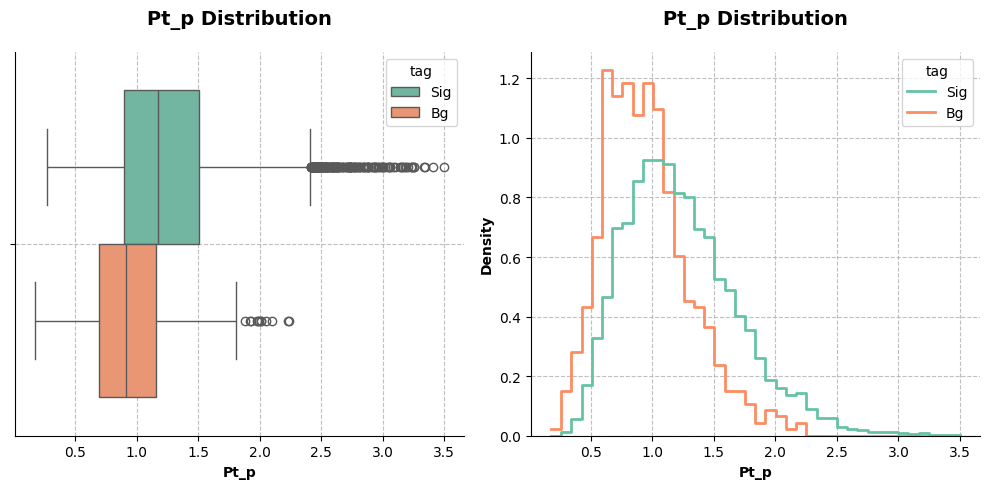

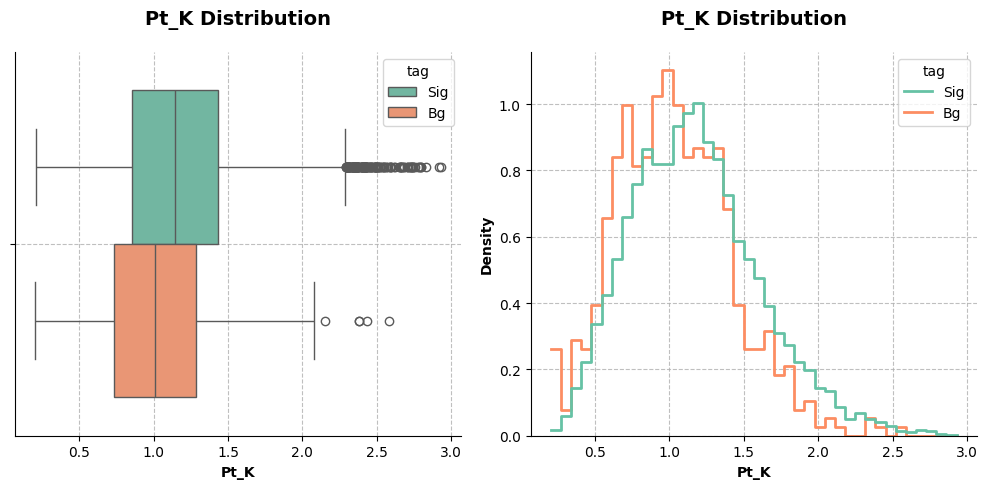

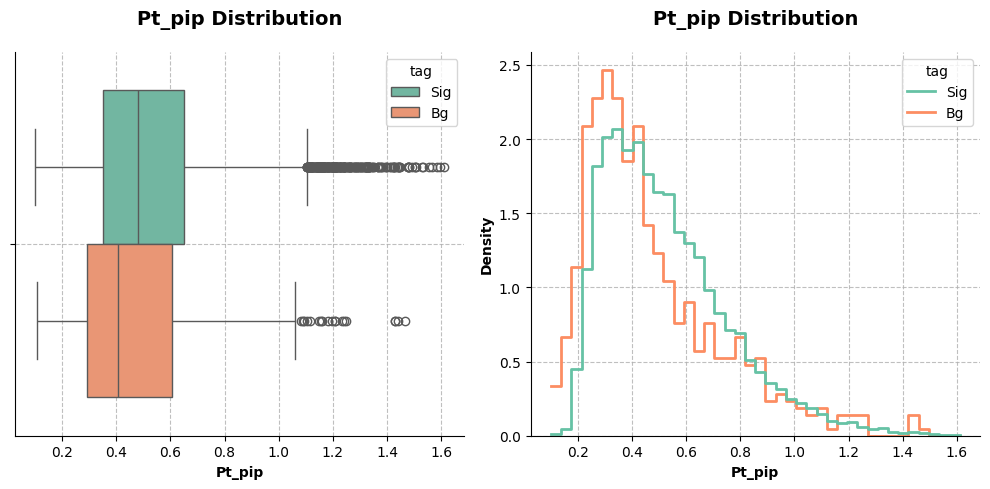

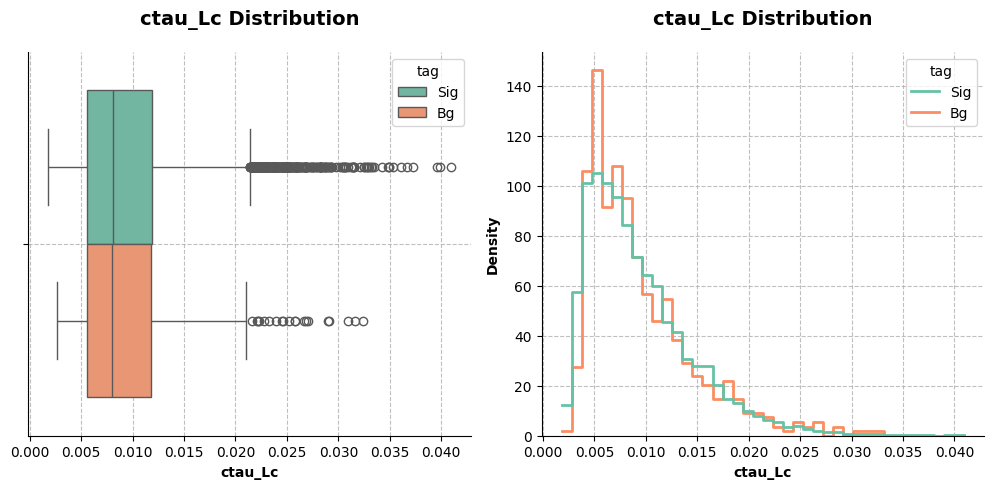

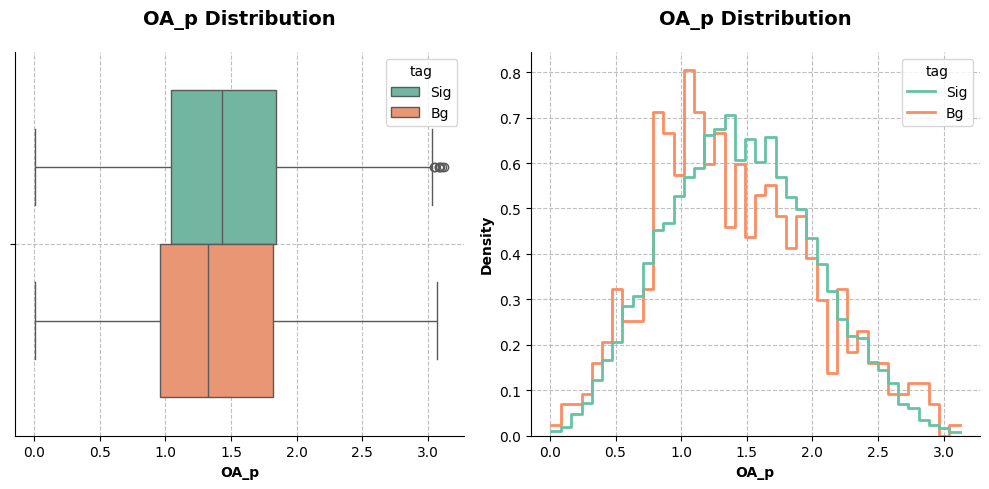

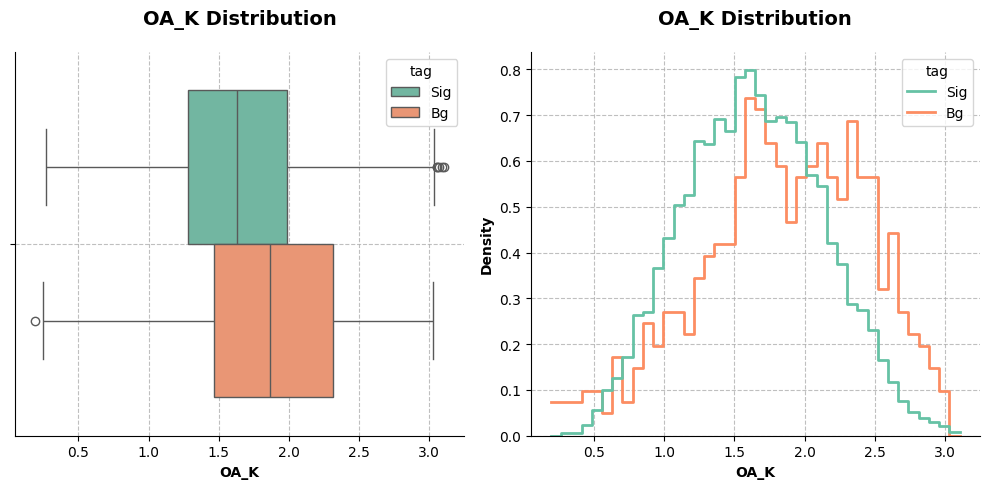

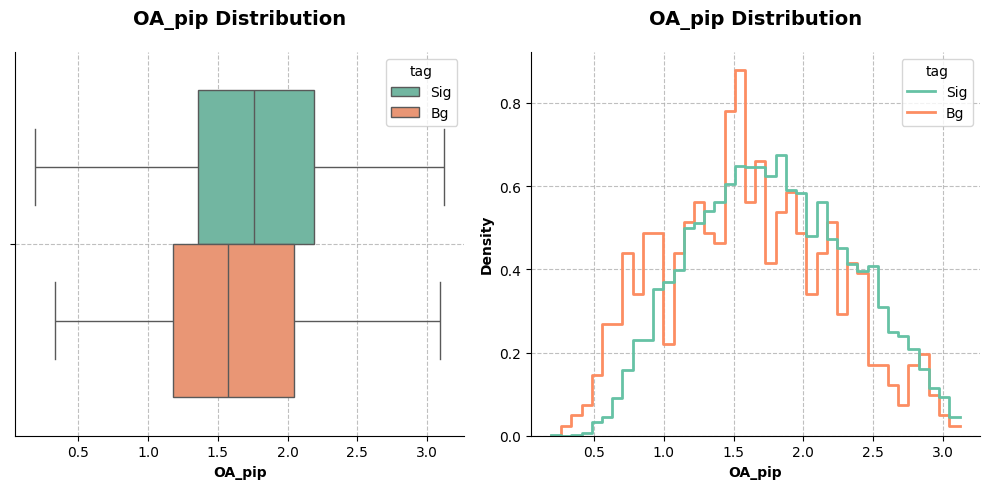

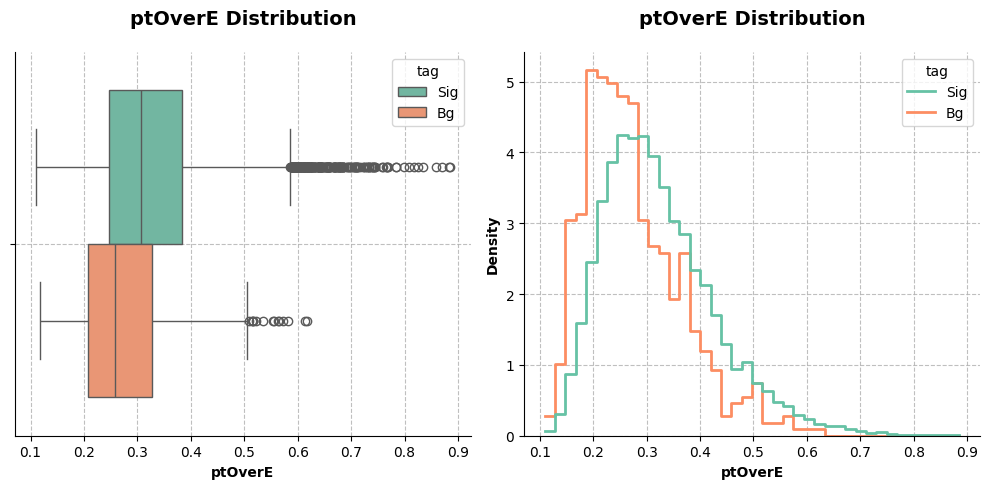

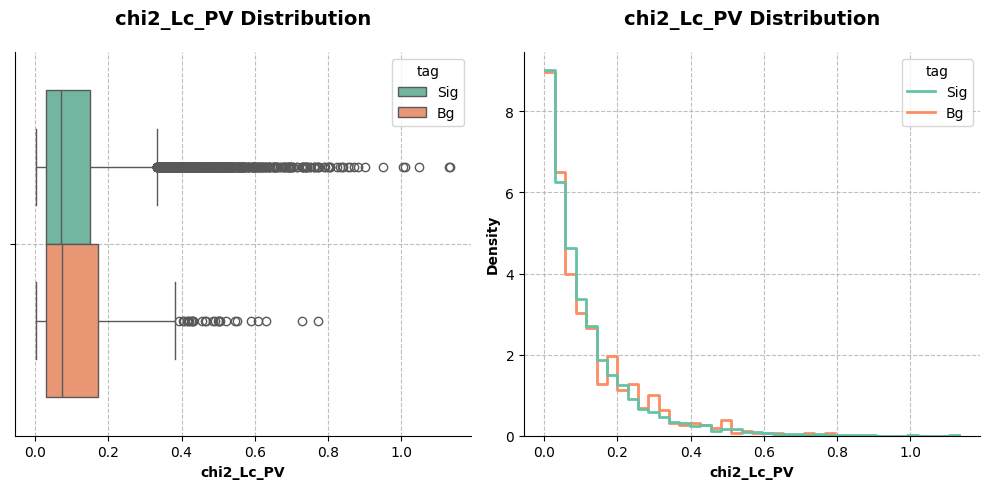

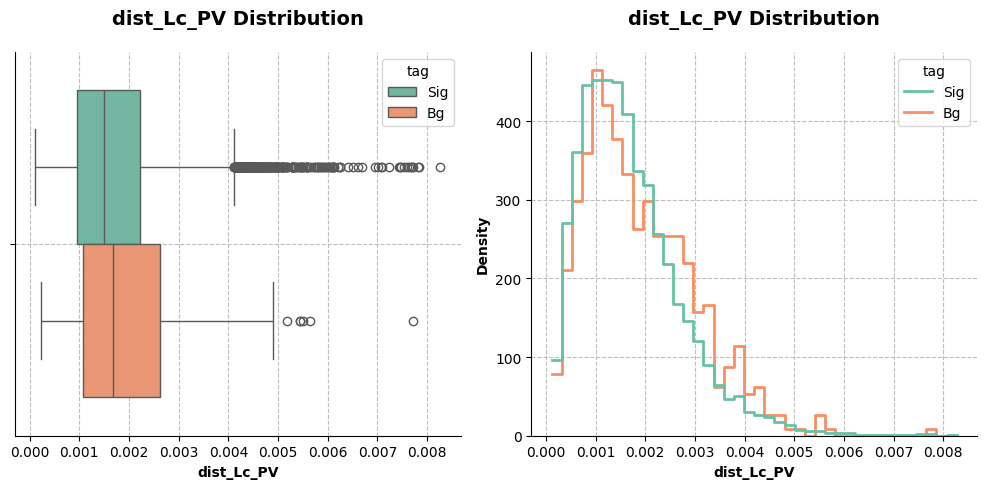

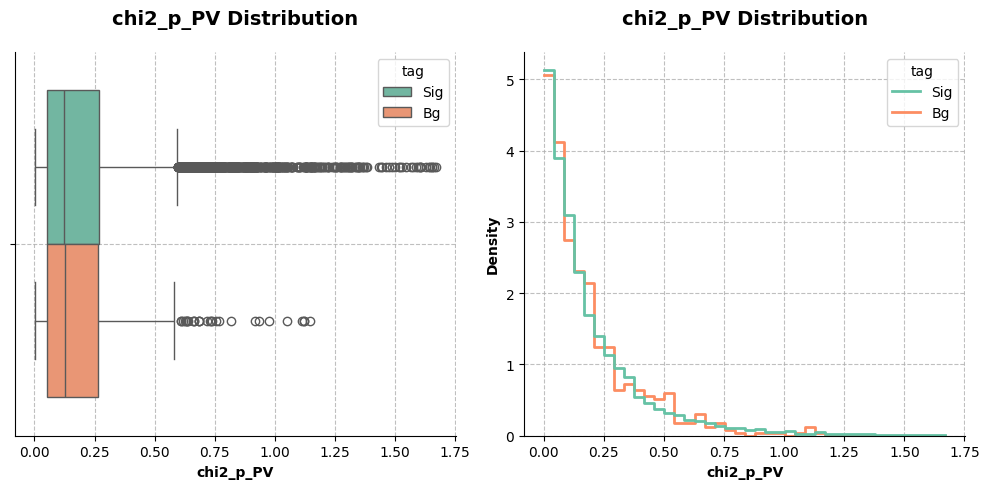

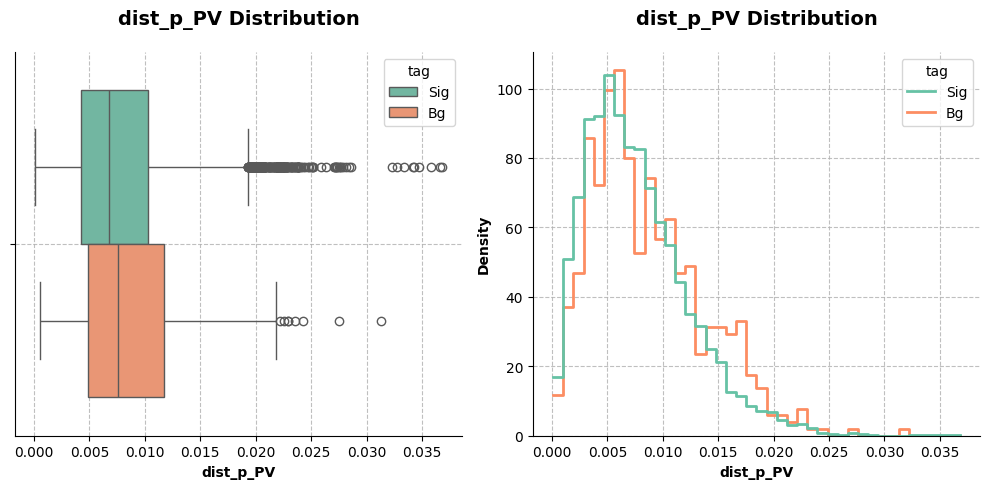

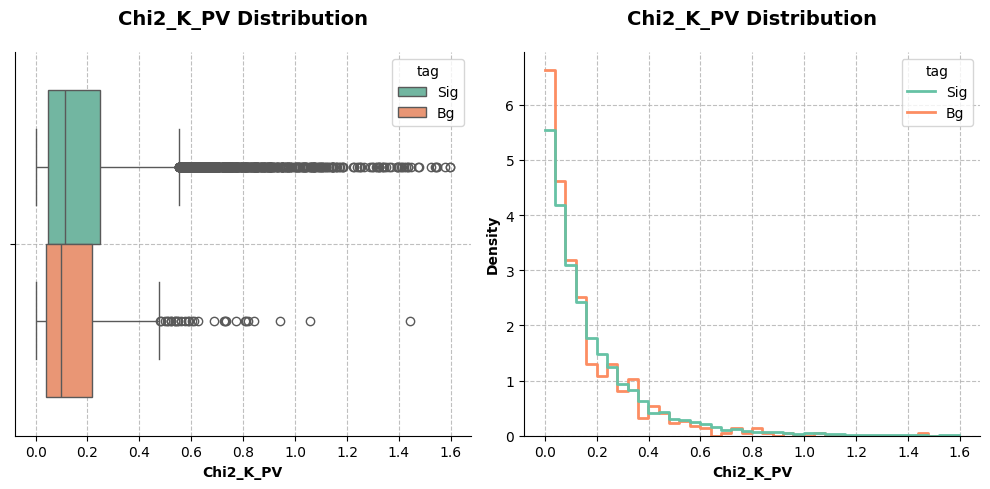

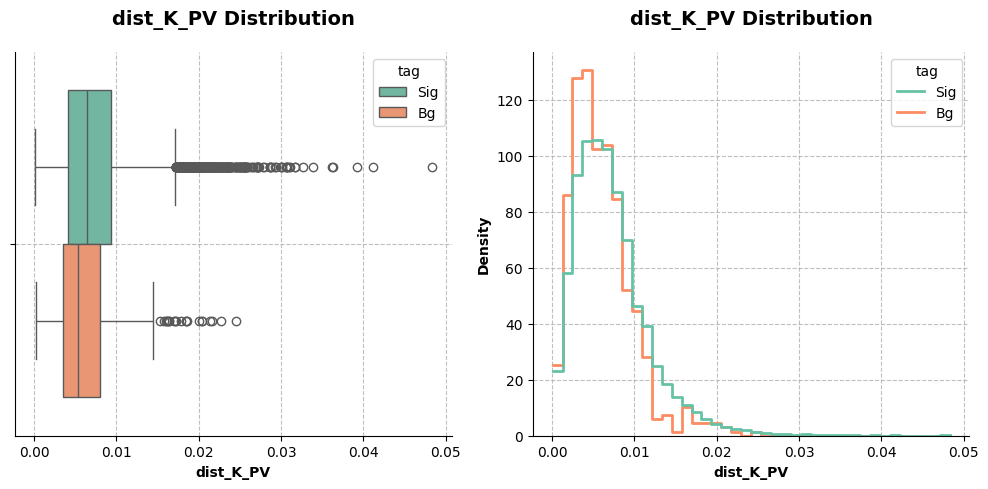

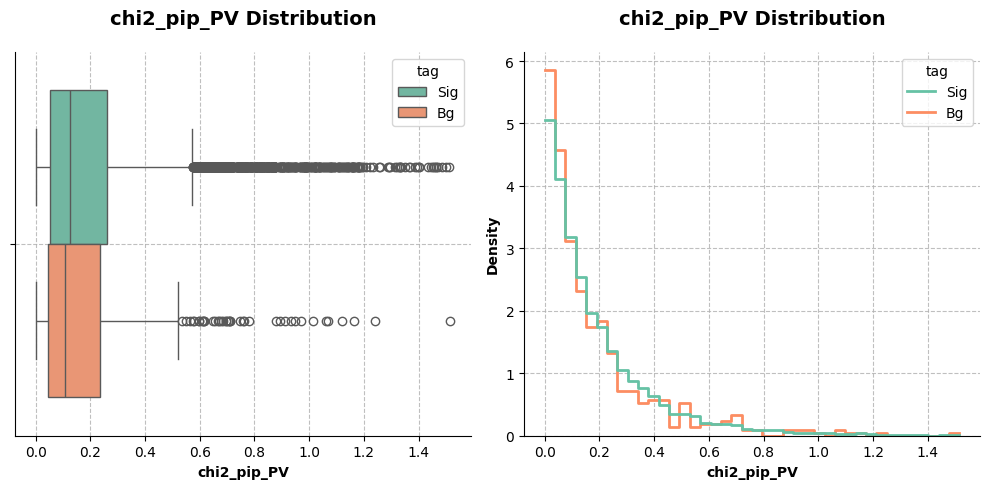

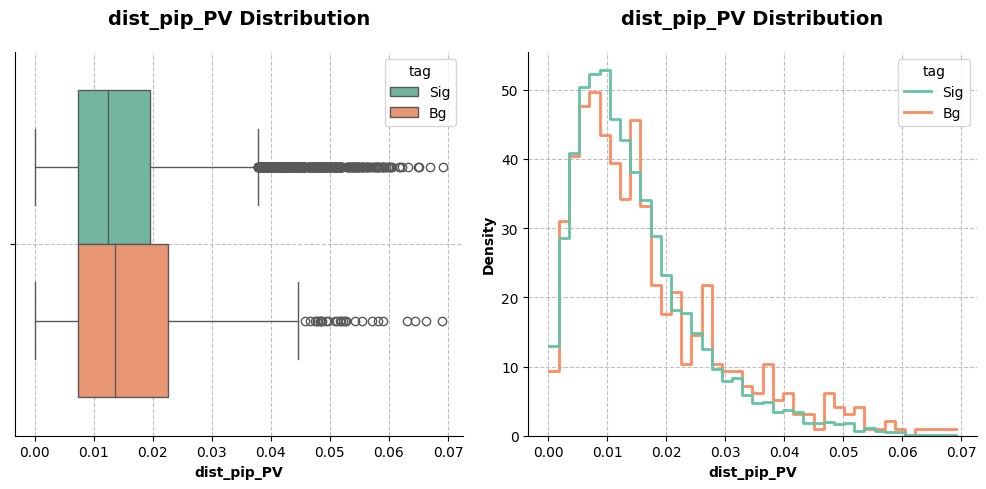

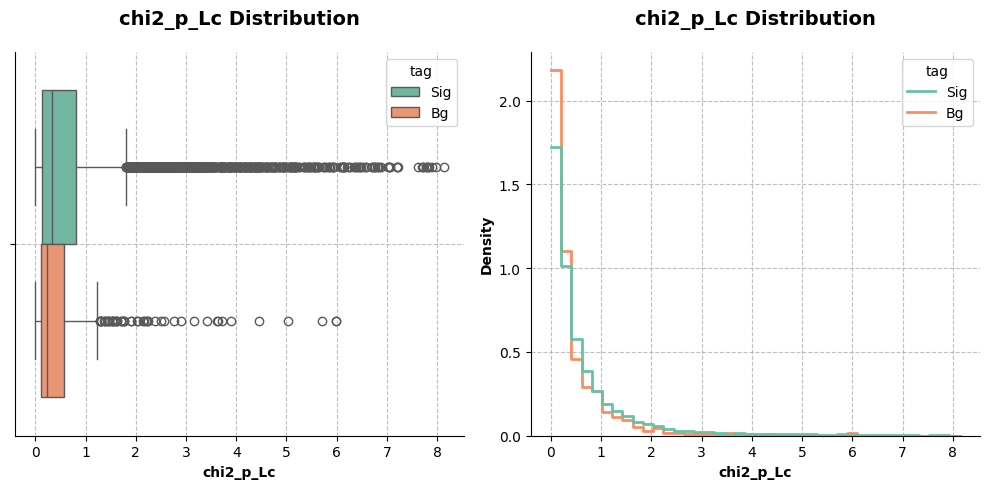

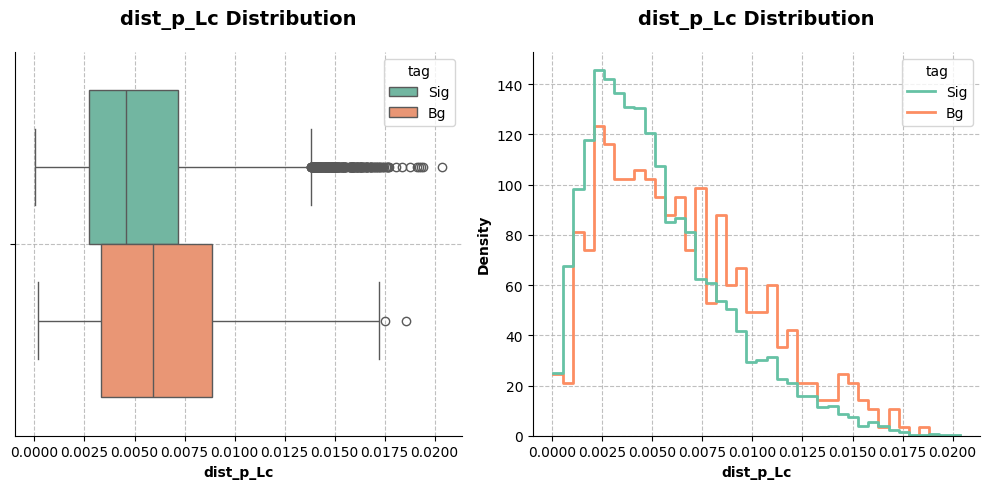

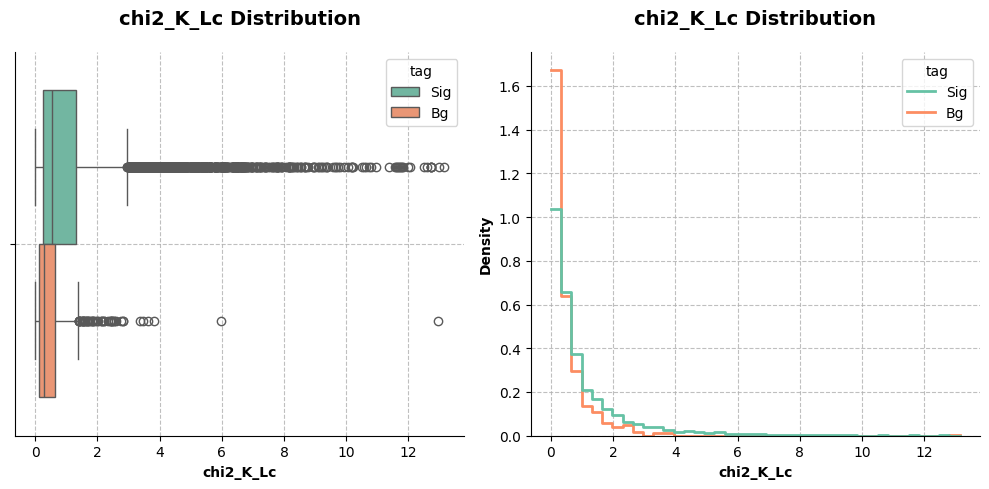

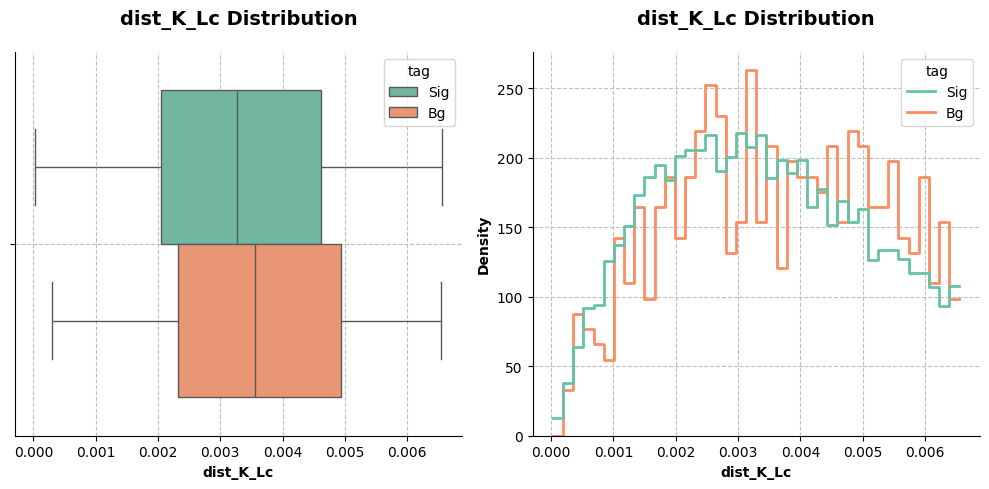

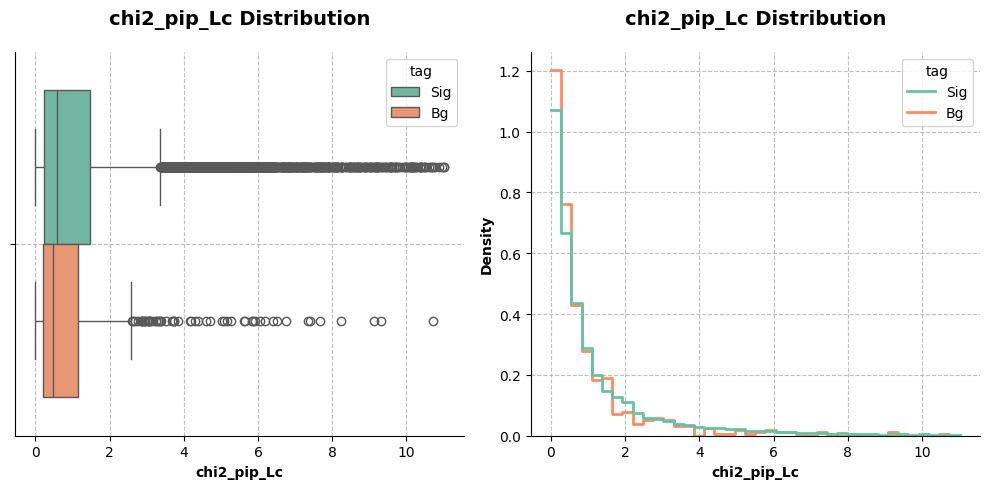

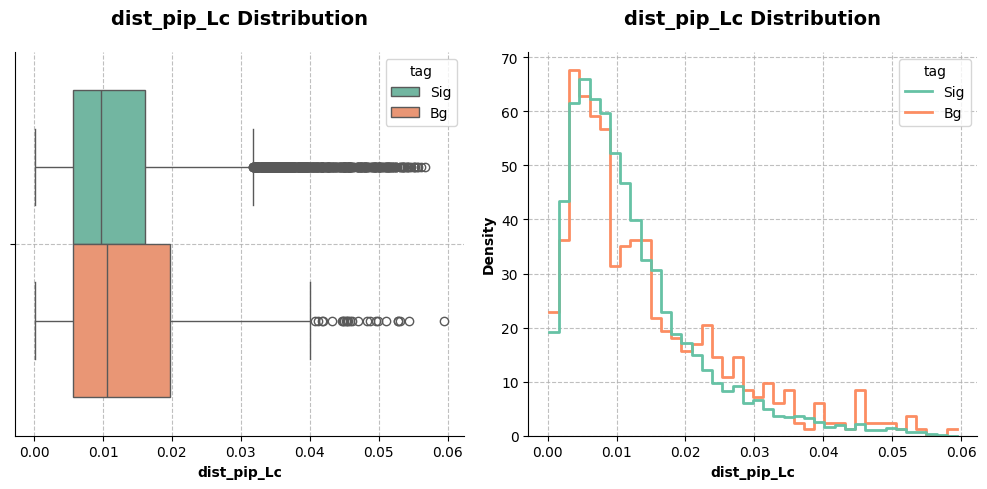

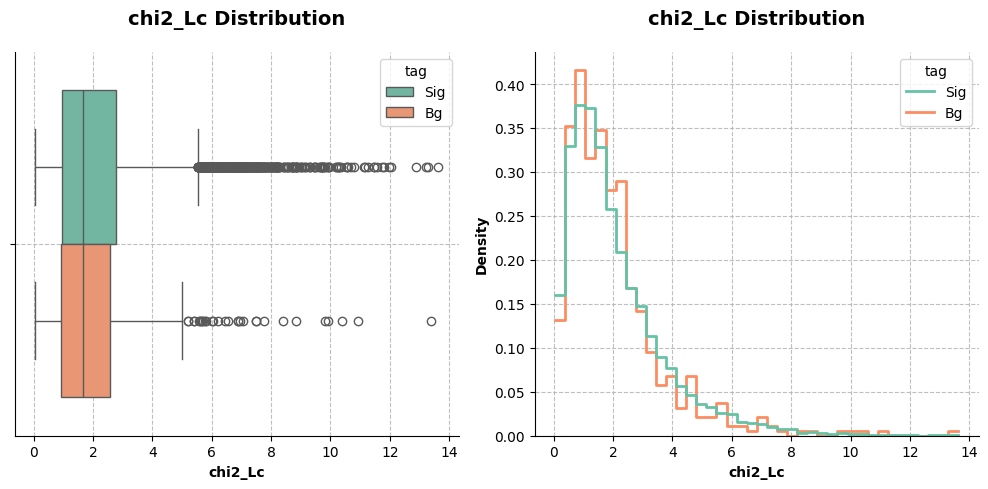

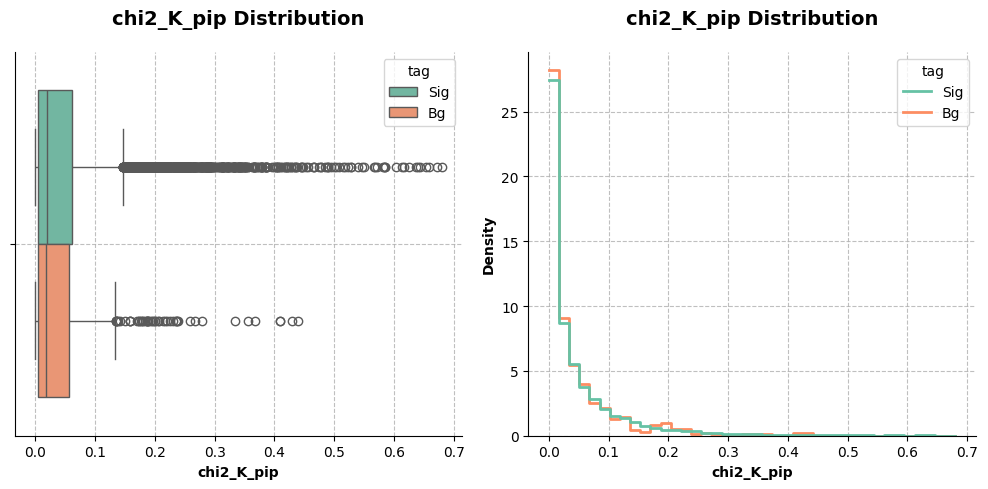

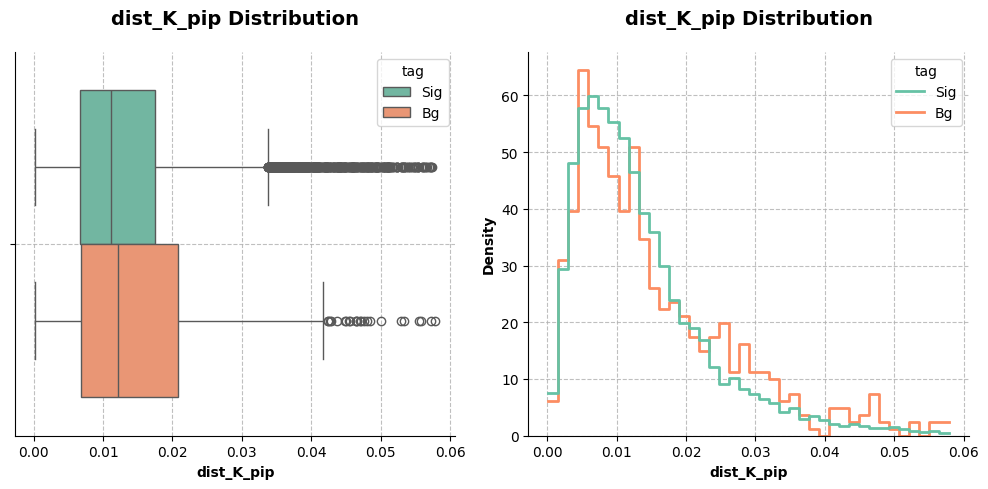

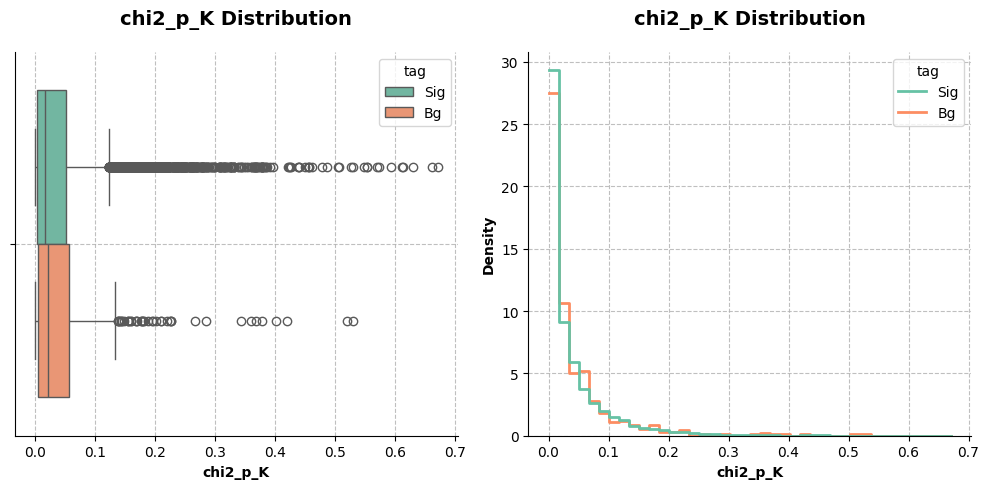

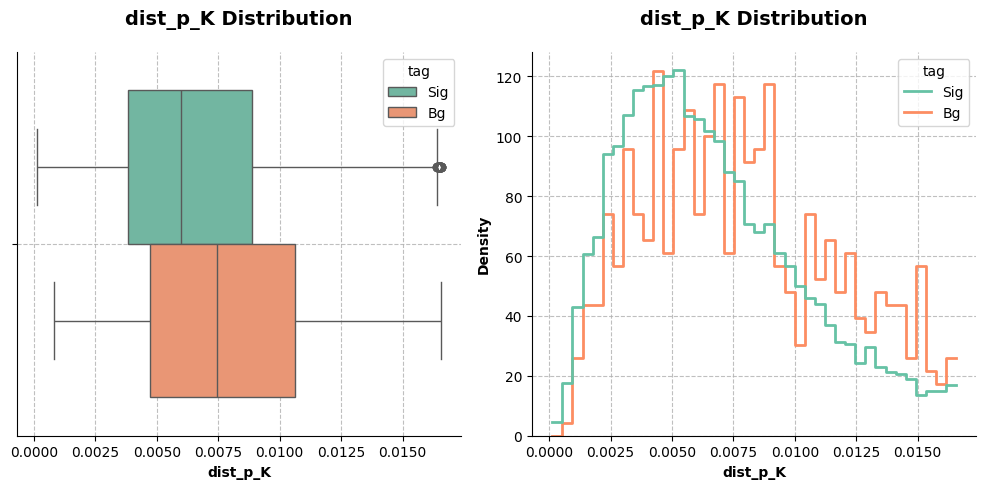

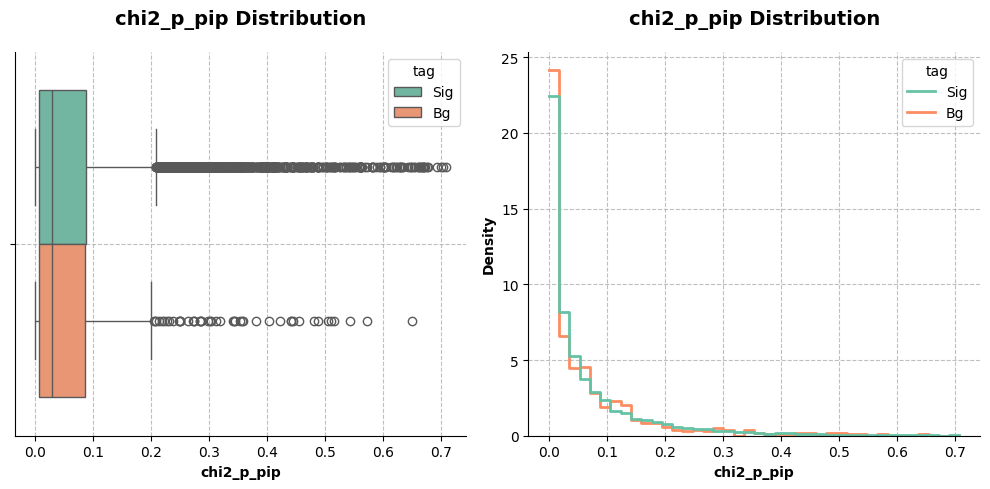

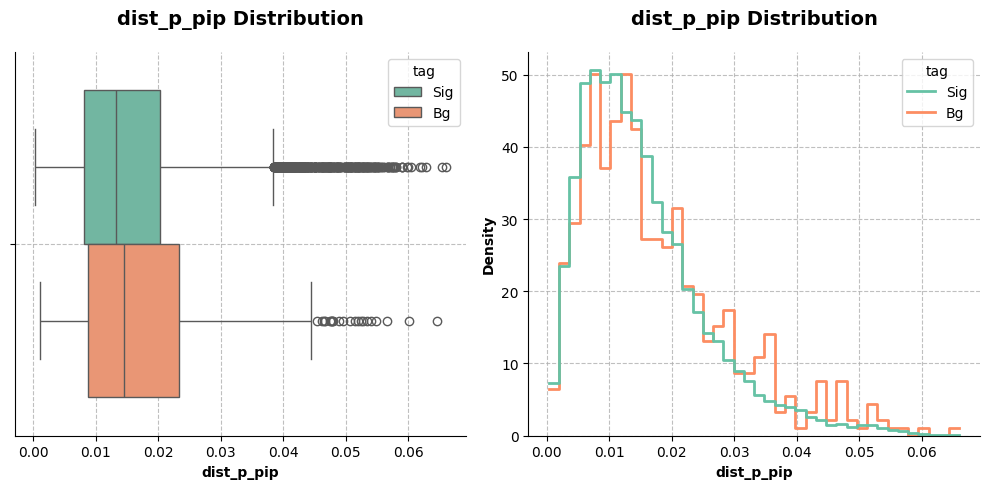

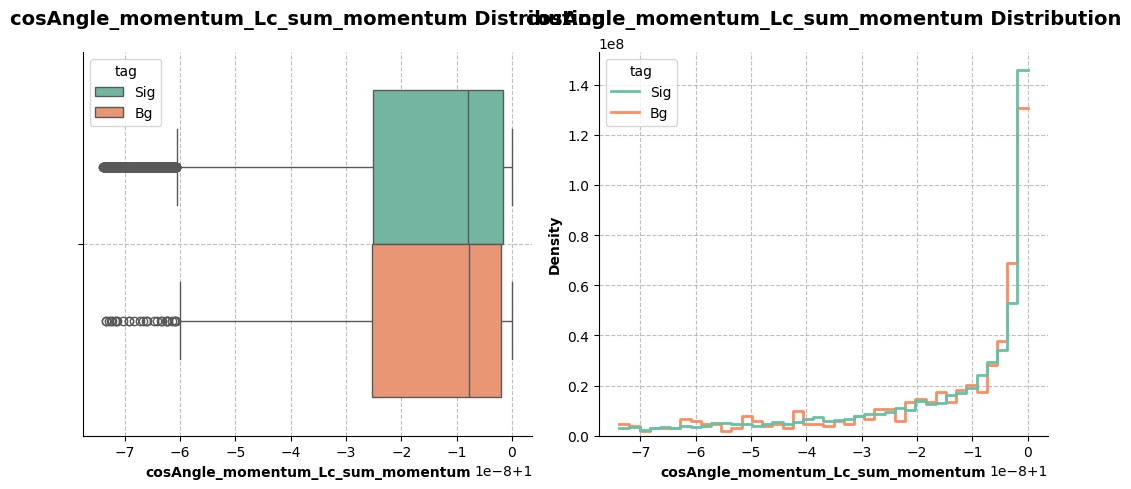

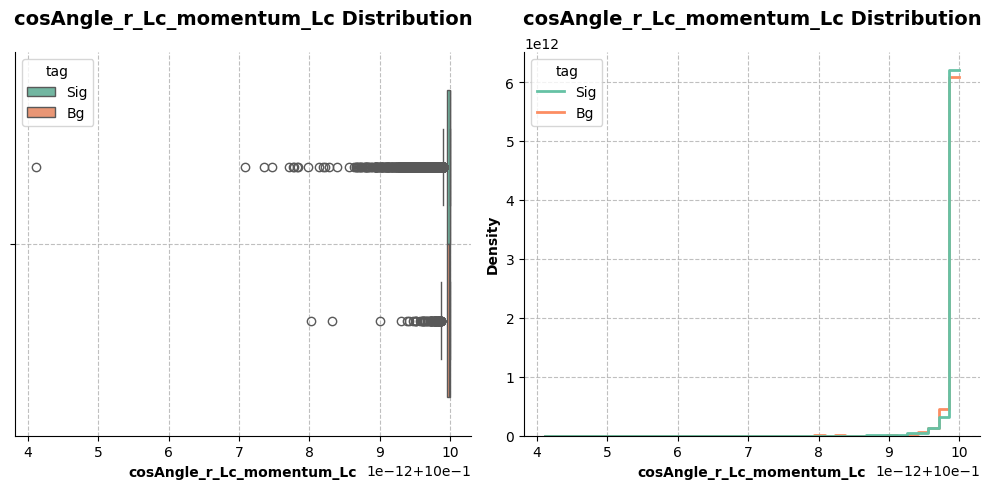

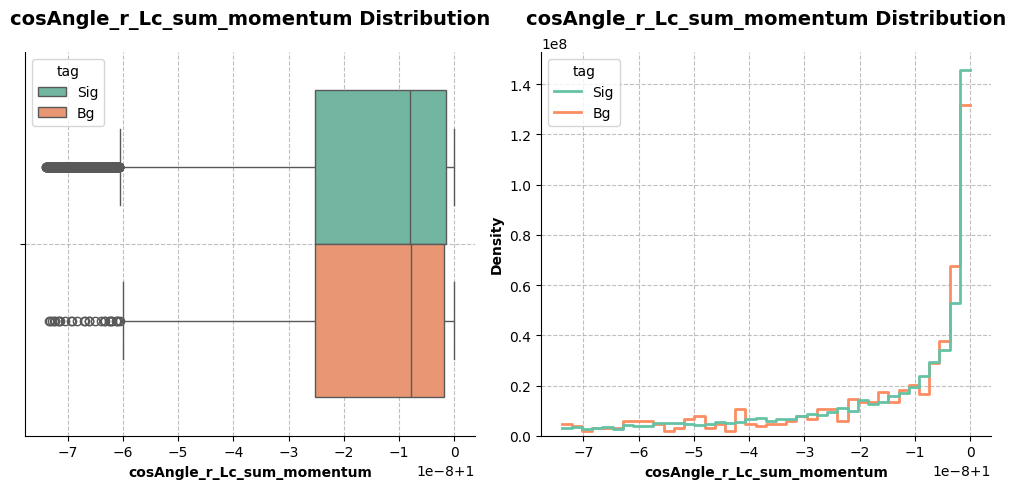

In [ ]:
from draw_scripts import draw_feature_distribution


for feature in phys_columns + topolog_columns + extra_top:
    
    draw_feature_distribution(
        df=proc_df,
        distr_name=feature,
        tag=None,
        hue='tag',
        bins=40,
        norma=True,
        cut_point=None,
        select_direction=None
    )

# Selection Var 2

In [16]:
# dist_p_K left significance
# dist_K_Lc left significance
# cosAngle_momentum_Lc_sum_momentum right significance
# lengthXY_Lc right ratio
# dist_Lc_PV left significance
# dist_p_PV left significance
# dist_p_pip left significance